# Dependencies and files

## Imports

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import gseapy
import os
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Global variables

## Load files

### Load clusters

Load clusters for human-specific genes

In [2]:
cluster_groups = pd.read_csv('../Specie-specific genes/results/human_clusters_edgeR_6.csv', index_col=0)
cluster_groups.columns = ['label']
cluster_groups.head()

label
LPL          0
SCN3B        0
RGS2         0
KIF21B       0
ST3GAL5      0

Load human/age-specific genes

In [3]:
hs_groups = pd.read_csv('../Specie-specific genes/results/age_hs_groups.csv', index_col=0)
hs_groups.head()

label
LDHB     age-specific
NRXN2    age-specific
NDUFB10  age-specific
ZBTB46   age-specific
ASAP2    age-specific

In [4]:
human_specific_genes = cluster_groups.index.to_list()
human_specific_genes[:5]

['LPL', 'SCN3B', 'RGS2', 'KIF21B', 'ST3GAL5']

### Load EdgeR results

In [5]:
dirpath = 'results/DE'
res_edgeR = dict()

for file in os.listdir(dirpath):
    # read celltype name
    celltype = file.rstrip('.csv').lstrip('degenes_')
    # read DE results to DataFrame
    df = pd.read_csv(f'{dirpath}/{file}', index_col=0).reset_index(names='names')
    # add a direction to the F-score
    df['score'] =  df['F'] * np.heaviside(df['F'], 0) * np.sign(df['logFC'])
    # save to the dict
    res_edgeR[celltype] = df

res_edgeR.keys()

dict_keys(['AST-FB', 'AST-PP', 'Endothelial', 'IN-PV', 'IN-SST', 'IN-VIP', 'L2.3', 'L4', 'L5.6-CC', 'L5.6', 'Microglia', 'Neu-mat', 'Neu-NRGN-I', 'Neu-NRGN-II', 'Oligodendrocyte', 'OPC'])

In [6]:
res_edgeR['AST-FB'].head()

names     logFC     logCPM            F         PValue            FDR  \
0    SLC1A2  4.563399  10.062126  3406.539134  3.325113e-119  5.821940e-115   
1     ACSS1  5.100352   5.457602  1935.746332  9.433703e-103   8.258736e-99   
2   SLCO1C1  5.498323   5.316373  1689.280179  2.555864e-101   1.491688e-97   
3     GPR98  5.261024   8.350420  2863.644210   1.527427e-98   6.685930e-95   
4  SLC25A18  5.001416   5.196514  1569.793480   7.611561e-96   2.665417e-92   

         score  
0  3406.539134  
1  1935.746332  
2  1689.280179  
3  2863.644210  
4  1569.793480

### Load chimp-specific genes

Load clusters for chimp-specific genes

In [7]:
chimp_cluster_groups = pd.read_csv('../Specie-specific genes/results/chimp_clusters_edgeR_4.csv', index_col=0)
chimp_cluster_groups.columns = ['label']
chimp_cluster_groups.head()

label
ANK3         0
BCL6         0
RIPOR2       0
TPD52L1      0
ARF5         1

In [8]:
chimp_specific_genes = chimp_cluster_groups.index.to_list()
chimp_specific_genes[:5]

['ANK3', 'BCL6', 'RIPOR2', 'TPD52L1', 'ARF5']

### Load pseudobulks

In [9]:
adata_pb = sc.read_h5ad('results/pb_adata_diffexpr.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 167 × 15922
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'start_position', 'end_position', 'chromosome_name', 'gene_biotype', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_colors', 'dendrogram_cluster', 'diagnosis_colors', 'hvg', 'log1p', 'logreg', 'neighbors', 'pca', 'region_colors', 'sample_colors', 't-test', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'psbulk_props'
    obsp: 'connectivities', 'distances'

Create celltypes list

In [10]:
celltypes = adata_pb.obs.cluster.unique().tolist()
celltypes

['AST-FB',
 'AST-PP',
 'Endothelial',
 'IN-PV',
 'IN-SST',
 'IN-VIP',
 'L2/3',
 'L4',
 'L5/6',
 'L5/6-CC',
 'Microglia',
 'Neu-NRGN-I',
 'Neu-NRGN-II',
 'Neu-mat',
 'OPC',
 'Oligodendrocytes']

Scale pseudobulk data

In [11]:
genes = adata_pb.var_names.intersection(human_specific_genes + chimp_specific_genes)
scaled_adata_pb = sc.pp.scale(adata_pb[:, genes], copy=True)

### Load Velmeshev data

In [12]:
adata_velm = sc.read_h5ad('results/adata_velm_umap.h5ad')
adata_velm

AnnData object with n_obs × n_vars = 52556 × 65217
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_colors', 'diagnosis_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'region_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Scale data for human-specific genes

In [13]:
genes = adata_velm.var_names.intersection(human_specific_genes + chimp_specific_genes)
scaled_adata_list = list()

for sample in adata_velm.obs['sample'].unique():
    scaled_adata_list.append(sc.pp.scale(adata_velm[adata_velm.obs['sample'] == sample, genes], copy=True))

scaled_adata = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_adata

AnnData object with n_obs × n_vars = 52556 × 75
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'diagnosis_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Usefull functions

In [14]:
def create_rank_df(adata, group, key, gene_col='names', score_col='scores', lfc_col='logfoldchanges', method='score', pval_cutoff=None):
    """
    Creates a DataFrame with ranked genes based on the results of DE (differential expression) analysis
    """
    # read results for DE
    de_res = sc.get.rank_genes_groups_df(adata, group=group, key=key, pval_cutoff=pval_cutoff)
    de_res = de_res.set_index(gene_col)
    # choose a method to create ranked gene list based on DE results
    if method == 'score':
        score_values = de_res[score_col]
    elif method == 'lfc_product':
        score_values = de_res['logfoldchanges'].abs() * de_res[score_col]
    else:
        raise ValueError('No such method')
    # create df with ranked genes
    gene_rank_df = score_values.sort_values(ascending=False).to_frame()
    return gene_rank_df

In [15]:
def enrich_celltypes(celltypes, gene_sets, adata=None, key=None, gene_col='names', score_col='scores', lfc_col='logfoldchanges', method='score', pval_cutoff=None, gsea_kw=None):
    """
    Find enrichment of gene_sets`for ranked gene lists
    """
    # set gsea parameters
    gsea_standart_kw = {
        'threads': 4,
        'min_size': 0,
        'max_size': 1000,
        'permutation_num': 1000, # reduce number to speed up testing
        'outdir': None, # don't write to disk
        'seed': 4,
        'verbose': True}
    
    if gsea_kw:
        gsea_standart_kw.update(gsea_kw)

    celltype_list = celltypes if adata else celltypes.keys()

    # results list
    res_df_list = list()
    # enrichment for each celltype
    for celltype in tqdm(celltype_list):
        # create a DataFrame with ranked genes
        if adata:
            rank_df = create_rank_df(adata, group=celltype, key=key, gene_col=gene_col, score_col=score_col, lfc_col=lfc_col, method=method, pval_cutoff=pval_cutoff)
        else:
            rank_df = celltypes[celltype].set_index(gene_col)[score_col].sort_values(ascending=False).to_frame()
        # enrich gene_sets based on ranked genes list
        gsea_res = gseapy.prerank(rnk=rank_df, gene_sets=gene_sets, **gsea_standart_kw)
        # save enrichment results
        res_df = gsea_res.res2d
        res_df['celltype'] = celltype
        res_df_list.append(res_df)
    # create DataFrame with results
    enrich_res = pd.concat(res_df_list, axis=0)
    return enrich_res

In [16]:
def process_enrichment_df(enrich_df):
    """
    Process the DataFrame with enrichment results
    """
    # convert FDR to -log10(FDR)
    enrich_df['-log10(FDR)'] = -np.log10(enrich_df['FDR q-val'].astype(float) + 1e-3)
    # Add direction column
    enrich_df['direction'] = enrich_df['ES'].map(lambda x: 'enriched' if x > 0 else 'depleted')
    # add significance category column
    enrich_df['significant'] = enrich_df['FDR q-val'].map(lambda x: 'FDR < 0.05' if x < 0.05 else 'FDR >= 0.05')

In [17]:
def enrichment_plot(enrich_res, figsize=(7,9), dpi=100, xlabel='Enrichment score', **kw_scatterplot):
    # create figure object
    fig = plt.figure(figsize=figsize, dpi=dpi)

    # create scatterplot
    ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)

    # modify label parameters
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel("", fontsize=10)
    ax.grid(False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Enrichment

## Enrichment for all human-specific genes

Create a dict with genesets

In [18]:
geneset = {'human-specific genes': cluster_groups.index.to_list()}

### T-test

Specify DE test

In [19]:
key = 't-test'

Run enrichment for genesets

In [20]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:07:09,128 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:10,688 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:11,488 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:12,217 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:12,896 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:13,616 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.338086  1.204348  0.129129  0.129129   
0  prerank  human-specific genes -0.425328 -1.365869  0.061911  0.061911   

  FWER p-val  Tag %  Gene %  \
0      0.043  15/59  12.48%   
0   0.061911  28/59  24.10%   

                                          Lead_genes celltype  
0  MACF1;ASAP2;LHX2;ETFB;NRXN1;CHST10;AMZ2;ID2;CA...   AST-FB  
0  IGSF21;GNAI1;NUAK1;SCN3B;PDE1A;ATP1A3;CX3CL1;G...   AST-PP

Process enrichment results

In [21]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.338086  1.204348  0.129129  0.129129   
0  prerank  human-specific genes -0.425328 -1.365869  0.061911  0.061911   

  FWER p-val  Tag %  Gene %  \
0      0.043  15/59  12.48%   
0   0.061911  28/59  24.10%   

                                          Lead_genes celltype  -log10(FDR)  \
0  MACF1;ASAP2;LHX2;ETFB;NRXN1;CHST10;AMZ2;ID2;CA...   AST-FB     0.885625   
0  IGSF21;GNAI1;NUAK1;SCN3B;PDE1A;ATP1A3;CX3CL1;G...   AST-PP     1.201272   

  direction  significant  
0  enriched  FDR >= 0.05  
0  depleted  FDR >= 0.05

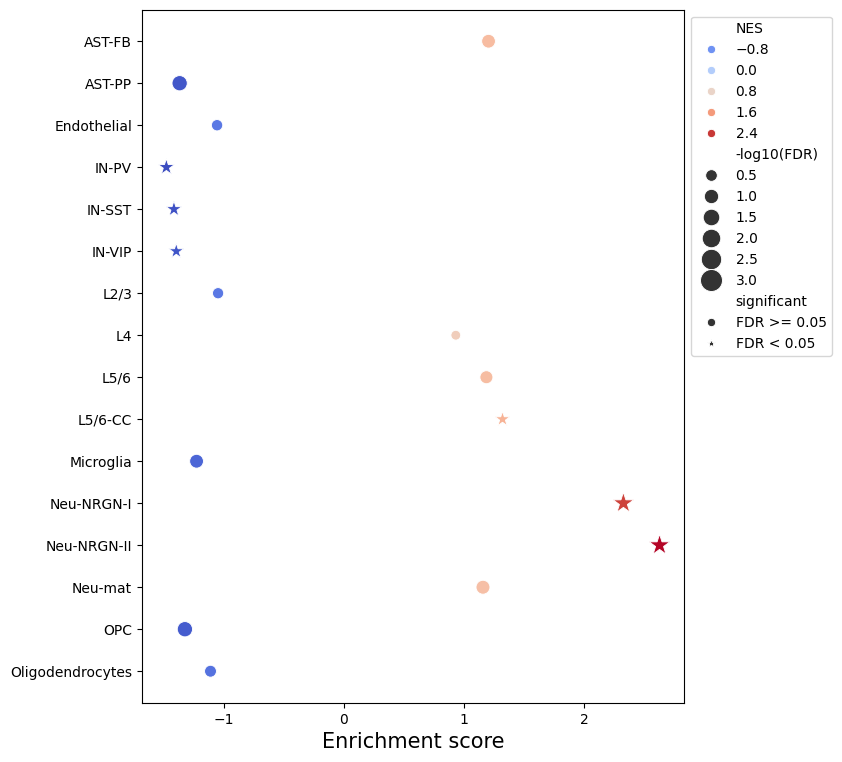

In [22]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Wilcoxon

Specify DE test

In [23]:
key = 'wilcoxon'

Run enrichment for genesets

In [24]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:07:20,259 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:20,943 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:21,622 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:22,295 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:22,995 [WARNING] Duplicated values found in preranked stats: 0.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:23,676 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.417139   1.15574  0.166667  0.166667   
0  prerank  human-specific genes -0.398963 -0.942926   0.56338   0.56338   

  FWER p-val  Tag %  Gene %  \
0      0.009  13/59  14.78%   
0    0.56338  28/59  24.57%   

                                          Lead_genes celltype  
0  LHX2;ID2;AMZ2;MACF1;ASAP2;CHST10;ETFB;CALR;COT...   AST-FB  
0  IGSF21;SCN3B;GNAI1;NUAK1;CX3CL1;ATP1A3;PDE1A;R...   AST-PP

Process enrichment results

In [25]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.417139   1.15574  0.166667  0.166667   
0  prerank  human-specific genes -0.398963 -0.942926   0.56338   0.56338   

  FWER p-val  Tag %  Gene %  \
0      0.009  13/59  14.78%   
0    0.56338  28/59  24.57%   

                                          Lead_genes celltype  -log10(FDR)  \
0  LHX2;ID2;AMZ2;MACF1;ASAP2;CHST10;ETFB;CALR;COT...   AST-FB     0.775553   
0  IGSF21;SCN3B;GNAI1;NUAK1;CX3CL1;ATP1A3;PDE1A;R...   AST-PP     0.248428   

  direction  significant  
0  enriched  FDR >= 0.05  
0  depleted  FDR >= 0.05

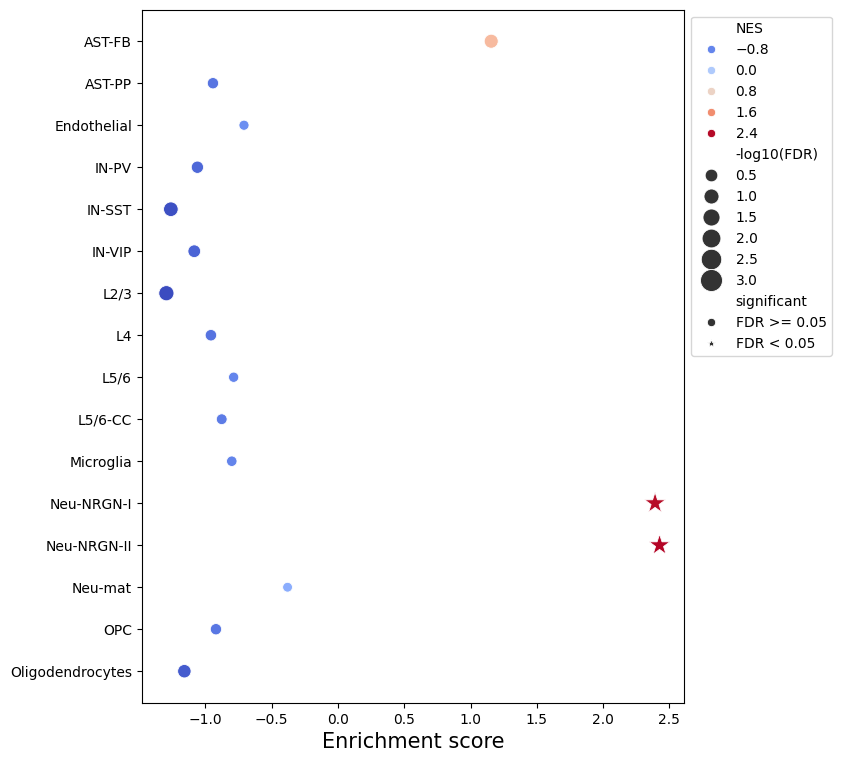

In [26]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Logreg

Specify DE test

In [27]:
key = 'logreg'

Run enrichment for genesets

In [28]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:07:32,936 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:33,627 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:34,295 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:34,929 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:35,546 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:36,153 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.423762  1.325803  0.084892  0.084892   
0  prerank  human-specific genes  -0.54654 -1.709954       0.0       0.0   

  FWER p-val  Tag %  Gene %  \
0      0.059  24/59  17.47%   
0        0.0  27/59  11.99%   

                                          Lead_genes celltype  
0  MACF1;NDUFB7;LHX2;SYNGAP1;KIF21B;PCP4;ETFB;ASA...   AST-FB  
0  SCN3B;NDUFB7;PDE1A;PCP4;CLSTN1;GPX4;ATP1A3;PTP...   AST-PP

Process enrichment results

In [29]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.423762  1.325803  0.084892  0.084892   
0  prerank  human-specific genes  -0.54654 -1.709954       0.0       0.0   

  FWER p-val  Tag %  Gene %  \
0      0.059  24/59  17.47%   
0        0.0  27/59  11.99%   

                                          Lead_genes celltype  -log10(FDR)  \
0  MACF1;NDUFB7;LHX2;SYNGAP1;KIF21B;PCP4;ETFB;ASA...   AST-FB     1.066047   
0  SCN3B;NDUFB7;PDE1A;PCP4;CLSTN1;GPX4;ATP1A3;PTP...   AST-PP     3.000000   

  direction  significant  
0  enriched  FDR >= 0.05  
0  depleted   FDR < 0.05

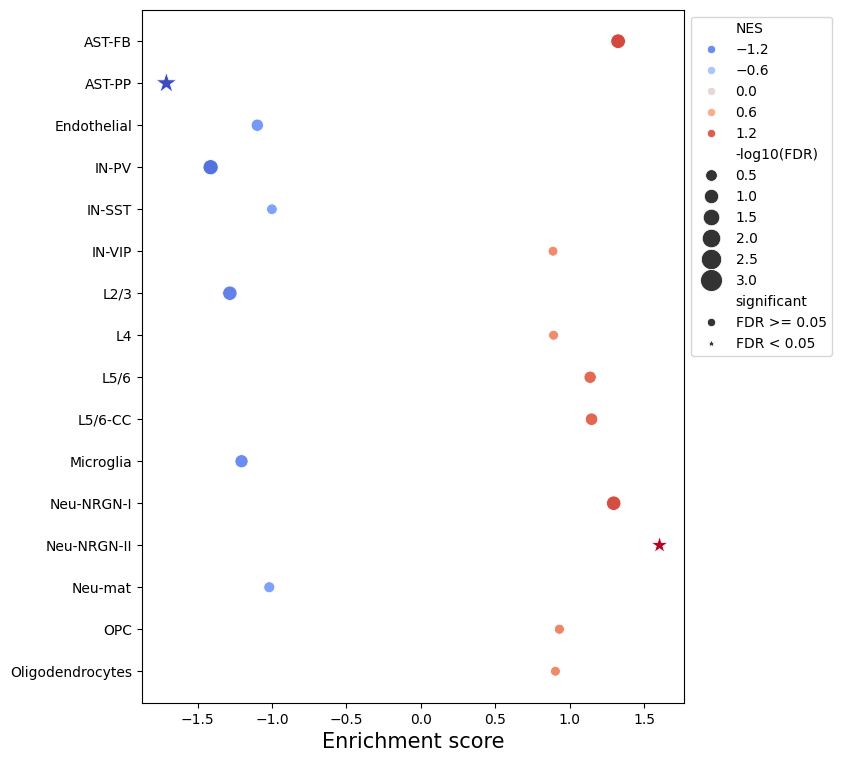

In [30]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR

Run enrichment for genesets

In [31]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True, 'weight': 0.5})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:07:42,279 [WARNING] Duplicated values found in preranked stats: 2.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:42,281 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:07:42,284 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:07:42,285 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-30 17:07:42,286 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:07:42,935 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:07:42,945 [WARNING] Duplicated values found in preranked stats: 1.29% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:07:42,946 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:07:42,947 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.327756  -1.10764  0.213043  0.213043   
0  prerank  human-specific genes -0.347632 -1.228704  0.067568  0.067568   

  FWER p-val  Tag %  Gene %  \
0   0.213043  20/60  10.44%   
0   0.067568  29/60  15.83%   

                                          Lead_genes celltype  
0  IGSF21;PDE1A;NUAK1;KLHL2;DLGAP4;CD47;GNAI1;ATP...   AST-FB  
0  IGSF21;NUAK1;GNAI1;SCN3B;PDE1A;ATP1A3;CX3CL1;N...   AST-PP

Process enrichment results

In [32]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.327756  -1.10764  0.213043  0.213043   
0  prerank  human-specific genes -0.347632 -1.228704  0.067568  0.067568   

  FWER p-val  Tag %  Gene %  \
0   0.213043  20/60  10.44%   
0   0.067568  29/60  15.83%   

                                          Lead_genes celltype  -log10(FDR)  \
0  IGSF21;PDE1A;NUAK1;KLHL2;DLGAP4;CD47;GNAI1;ATP...   AST-FB     0.669498   
0  IGSF21;NUAK1;GNAI1;SCN3B;PDE1A;ATP1A3;CX3CL1;N...   AST-PP     1.163881   

  direction  significant  
0  depleted  FDR >= 0.05  
0  depleted  FDR >= 0.05

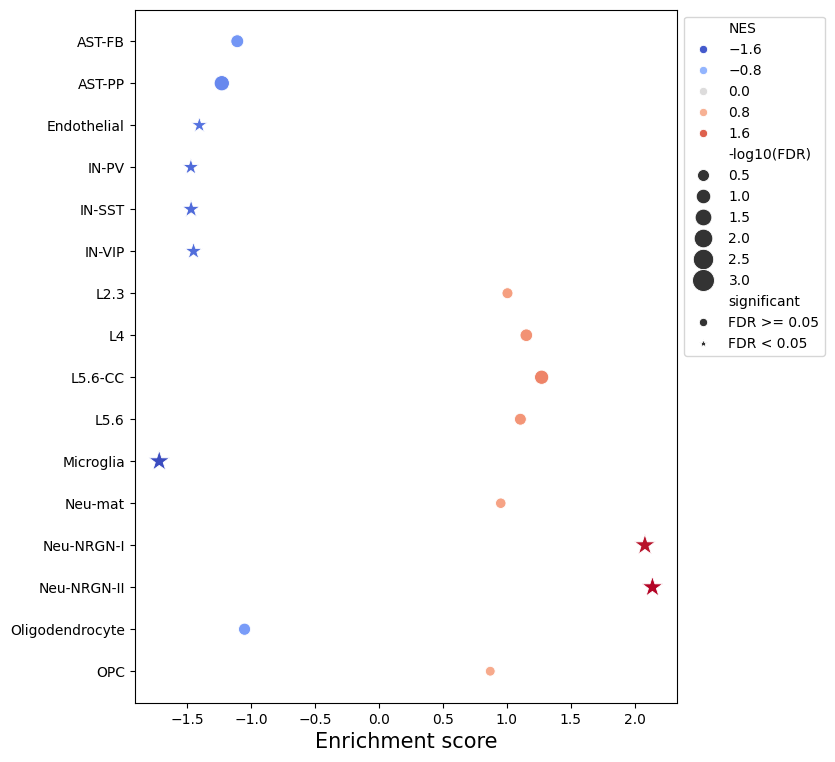

In [33]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)
enrich_norm = mpl.colors.TwoSlopeNorm(vcenter=0)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    hue_norm=enrich_norm,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR (logFC)

Run enrichment for genesets

In [34]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='logFC', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:07:52,974 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:07:52,976 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:07:52,976 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-30 17:07:52,977 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:07:53,634 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:07:53,651 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:07:53,655 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:07:53,657 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-30 17:07:53,658 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:07:54,323 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:07:54,335 [INFO] Parsing data files for GSEA............................

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.235487 -0.822298  0.788961  0.788961   
0  prerank  human-specific genes -0.341876 -1.316402  0.069307  0.069307   

  FWER p-val  Tag %  Gene %  \
0   0.788961  25/60  31.45%   
0   0.069307  28/60  24.43%   

                                          Lead_genes celltype  
0  IGSF21;MAZ;PDE1A;SULF2;RGS2;CX3CL1;IGFBP6;NUAK...   AST-FB  
0  IGSF21;SCN3B;NUAK1;CX3CL1;ATP1A3;PDE1A;GNAI1;R...   AST-PP

Process enrichment results

In [35]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.235487 -0.822298  0.788961  0.788961   
0  prerank  human-specific genes -0.341876 -1.316402  0.069307  0.069307   

  FWER p-val  Tag %  Gene %  \
0   0.788961  25/60  31.45%   
0   0.069307  28/60  24.43%   

                                          Lead_genes celltype  -log10(FDR)  \
0  IGSF21;MAZ;PDE1A;SULF2;RGS2;CX3CL1;IGFBP6;NUAK...   AST-FB     0.102394   
0  IGSF21;SCN3B;NUAK1;CX3CL1;ATP1A3;PDE1A;GNAI1;R...   AST-PP     1.153002   

  direction  significant  
0  depleted  FDR >= 0.05  
0  depleted  FDR >= 0.05

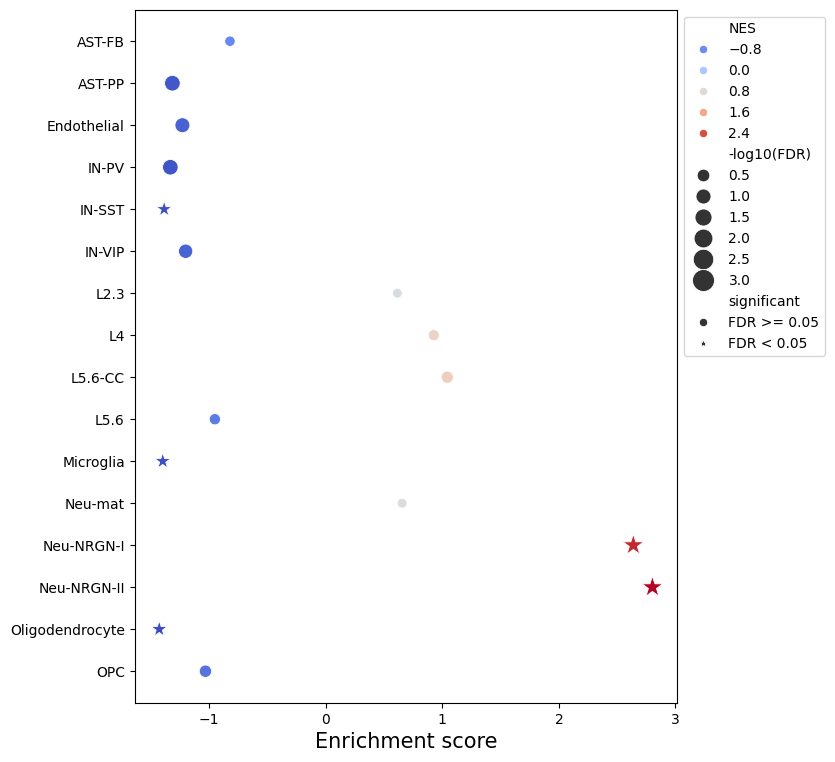

In [36]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Gene visualization

Calculate average normalized expression

In [37]:
genes = scaled_adata.var_names.intersection(human_specific_genes)
scaled_adata.obs[f'All HS genes'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head(3)

cluster     sample  individual region  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24       Neu-NRGN-II  1823_BA24        1823    ACC   
AAACGGGCACCAGATT-1_1823_BA24              L5/6  1823_BA24        1823    ACC   
AAAGATGAGTCCAGGA-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   

                              age sex diagnosis Capbatch Seqbatch  \
cell                                                                
AAACCTGGTACGCACC-1_1823_BA24   15   M   Control      CB8      SB3   
AAACGGGCACCAGATT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGAGTCCAGGA-1_1823_BA24   15   M   Control      CB8      SB3   

                              post-mortem interval (hours)  \
cell                                                         
AAACCTGGTACGCACC-1_1823_BA24                            18   
AAACGGGCACCAGATT-1_1823_BA24                            18   
AAAGATGAGTCCAGGA-1_1823_BA24                            18   

                              RNA Integrity Number  genes   UMIs  \
cell                                                               
AAACCTGGTACGCACC-1_1823_BA24                   7.0    622    774   
AAACGGGCACCAGATT-1_1823_BA24                   7.0   6926  24042   
AAAGATGAGTCCAGGA-1_1823_BA24                   7.0    624    830   

                              RNA mitochondr. percent  RNA ribosomal percent  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24                 2.454780               1.421189   
AAACGGGCACCAGATT-1_1823_BA24                 0.445055               0.428417   
AAAGATGAGTCCAGGA-1_1823_BA24                 0.240964               0.722892   

                              All HS genes  
cell                                        
AAACCTGGTACGCACC-1_1823_BA24      0.096139  
AAACGGGCACCAGATT-1_1823_BA24      0.393796  
AAAGATGAGTCCAGGA-1_1823_BA24     -0.107555

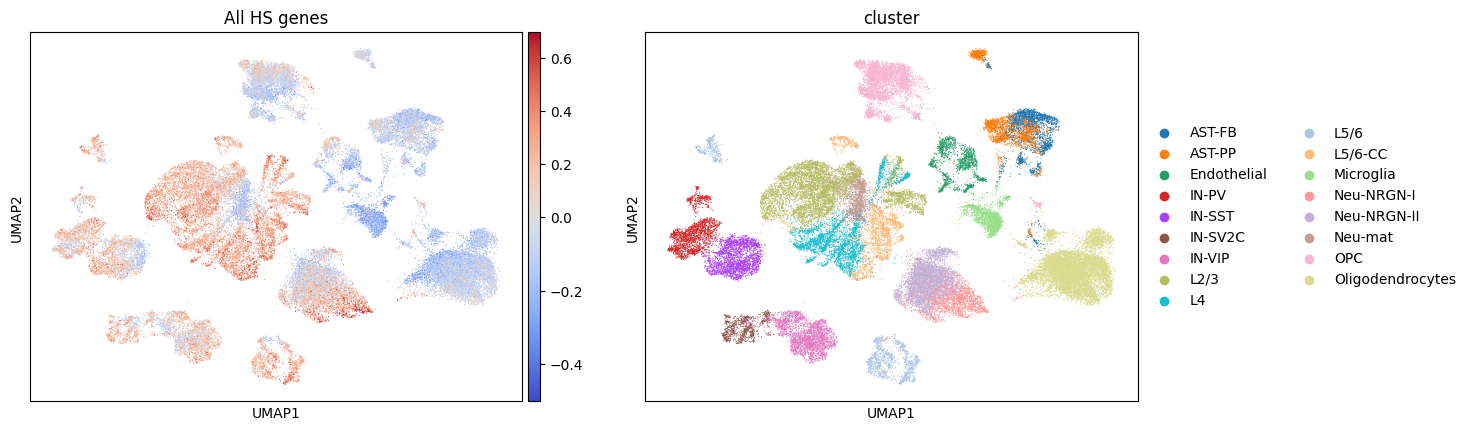

In [38]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.7, vmin=-0.5)

sc.pl.umap(scaled_adata, color=['All HS genes', 'cluster'], cmap=cmap, norm=norm)

## Enrich for HS/AS groups

Create geneset dict

In [39]:
gene_sets = dict()
for label in hs_groups.label.unique():
  gene_sets[label] = hs_groups[hs_groups.label == label].index.to_list()

### T-test

Specify DE test

In [40]:
key = 't-test'

Run enrichment for genesets

In [41]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:08:05,392 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:06,812 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:07,507 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:08,211 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:08,914 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:09,609 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank    maybe age-specific  0.421596  1.096505   0.35109       1.0   
1  prerank  maybe human-specific  0.447497  1.033011  0.424165  0.626559   

  FWER p-val Tag %  Gene %                              Lead_genes celltype  
0       0.46  3/15   5.53%                          MACF1;LHX2;ID2   AST-FB  
1      0.529  6/10  21.25%  CHST10;CALR;ALCAM;KIF21B;NDUFB7;MRPL51   AST-FB

Process enrichment results

In [42]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank    maybe age-specific  0.421596  1.096505   0.35109       1.0   
1  prerank  maybe human-specific  0.447497  1.033011  0.424165  0.626559   

  FWER p-val Tag %  Gene %                              Lead_genes celltype  \
0       0.46  3/15   5.53%                          MACF1;LHX2;ID2   AST-FB   
1      0.529  6/10  21.25%  CHST10;CALR;ALCAM;KIF21B;NDUFB7;MRPL51   AST-FB   

   -log10(FDR) direction  significant  
0    -0.000434  enriched  FDR >= 0.05  
1     0.202346  enriched  FDR >= 0.05

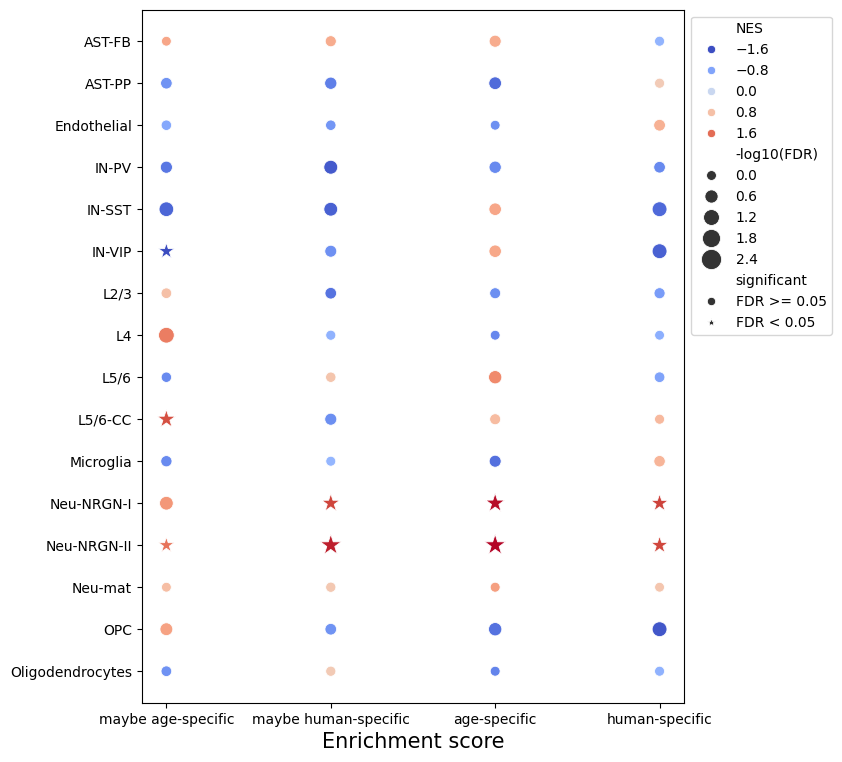

In [43]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

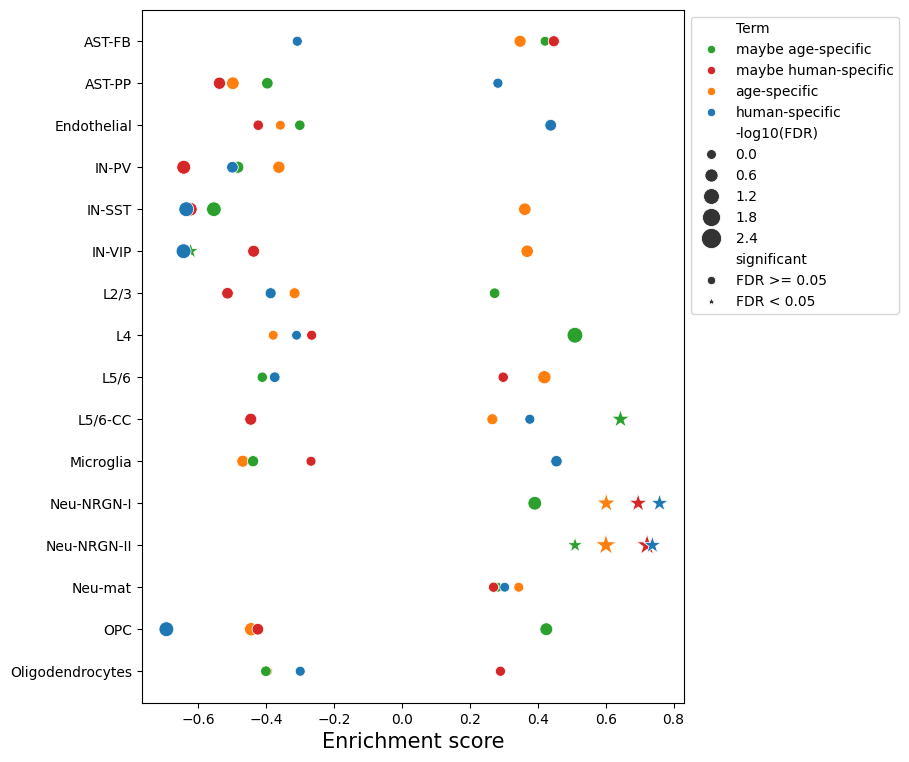

In [44]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

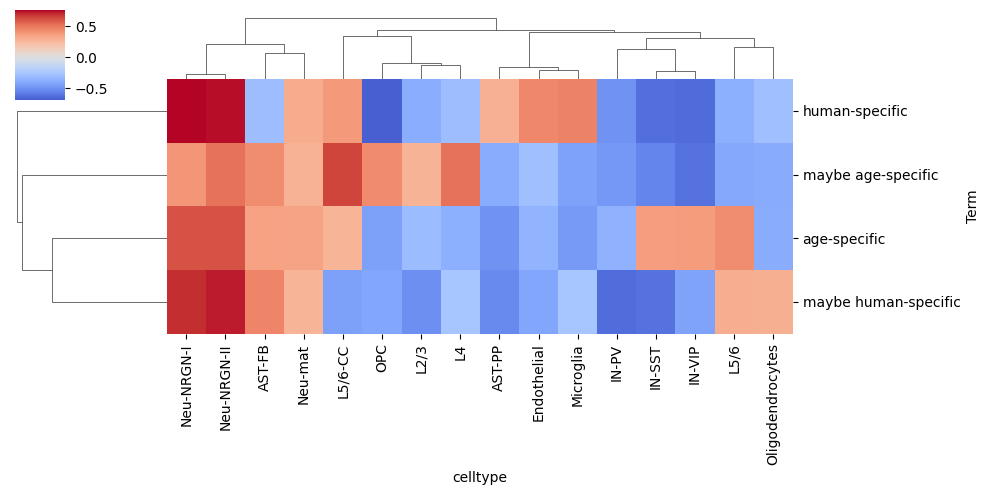

In [45]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

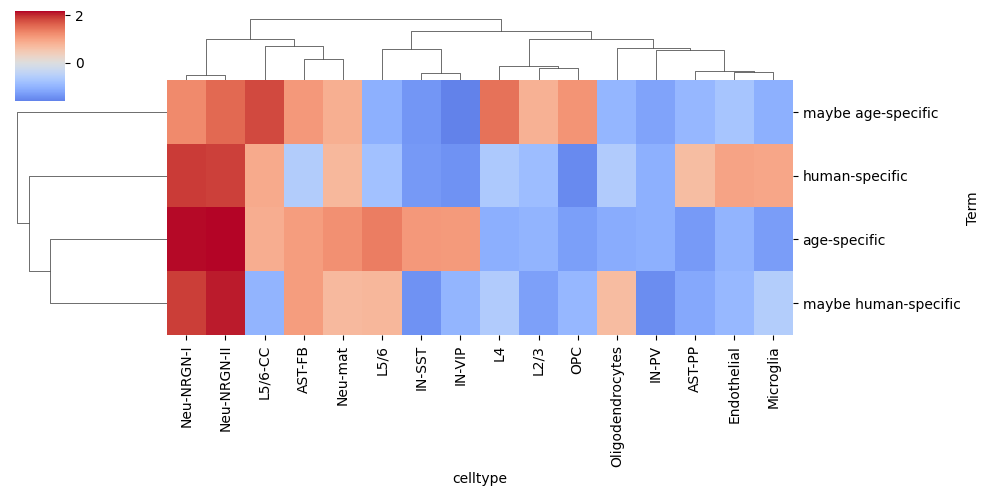

In [46]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

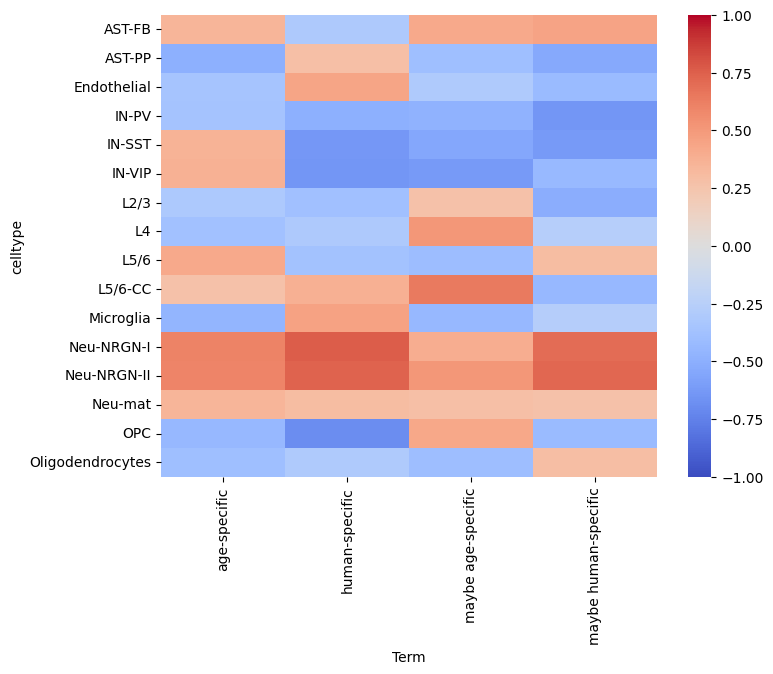

In [47]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Wilcoxon

Specify DE test

In [48]:
key = 'wilcoxon'

Run enrichment for genesets

In [49]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:08:17,515 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:18,251 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:18,984 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:19,737 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:20,458 [WARNING] Duplicated values found in preranked stats: 0.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:21,224 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.565159  1.134659  0.332258       1.0   
1  prerank        age-specific  0.412579  0.932386  0.586826       1.0   

  FWER p-val Tag %  Gene %                                         Lead_genes  \
0      0.346  3/15   3.51%                                     LHX2;ID2;MACF1   
1      0.528  8/26  18.56%  ASAP2;ETFB;COTL1;NRXN1;LDHB;NDUFB10;PPP1CC;SYN...   

  celltype  
0   AST-FB  
1   AST-FB

Process enrichment results

In [50]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.565159  1.134659  0.332258       1.0   
1  prerank        age-specific  0.412579  0.932386  0.586826       1.0   

  FWER p-val Tag %  Gene %                                         Lead_genes  \
0      0.346  3/15   3.51%                                     LHX2;ID2;MACF1   
1      0.528  8/26  18.56%  ASAP2;ETFB;COTL1;NRXN1;LDHB;NDUFB10;PPP1CC;SYN...   

  celltype  -log10(FDR) direction  significant  
0   AST-FB    -0.000434  enriched  FDR >= 0.05  
1   AST-FB    -0.000434  enriched  FDR >= 0.05

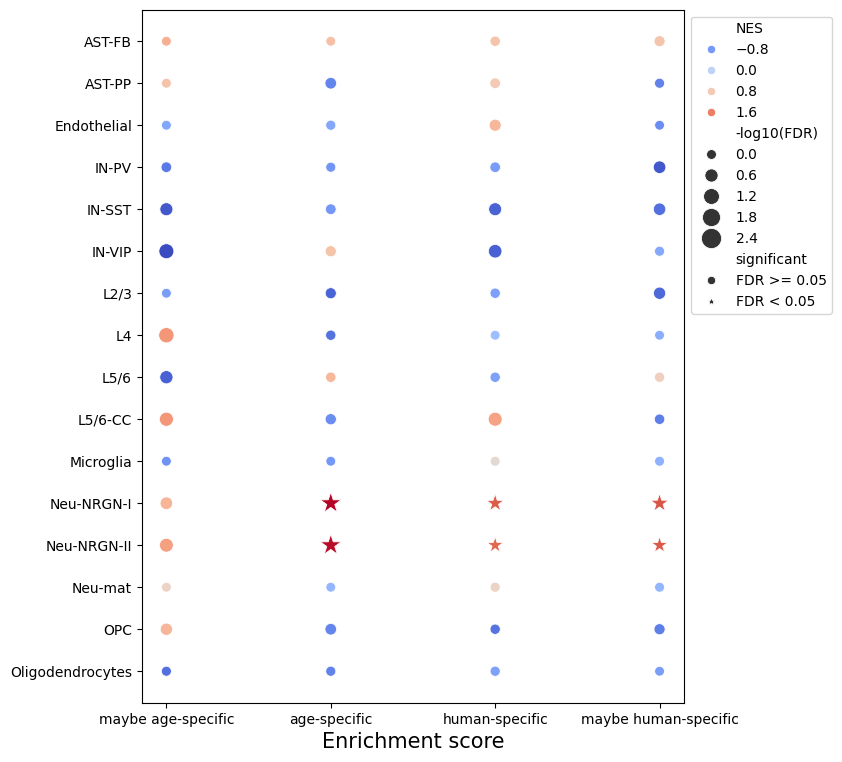

In [51]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

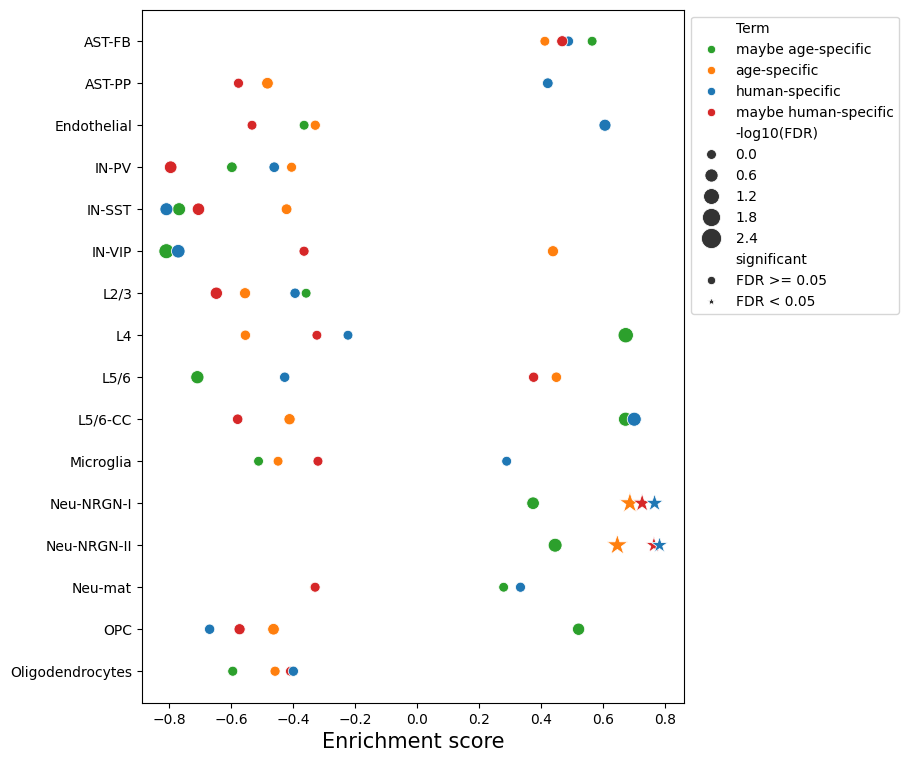

In [52]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

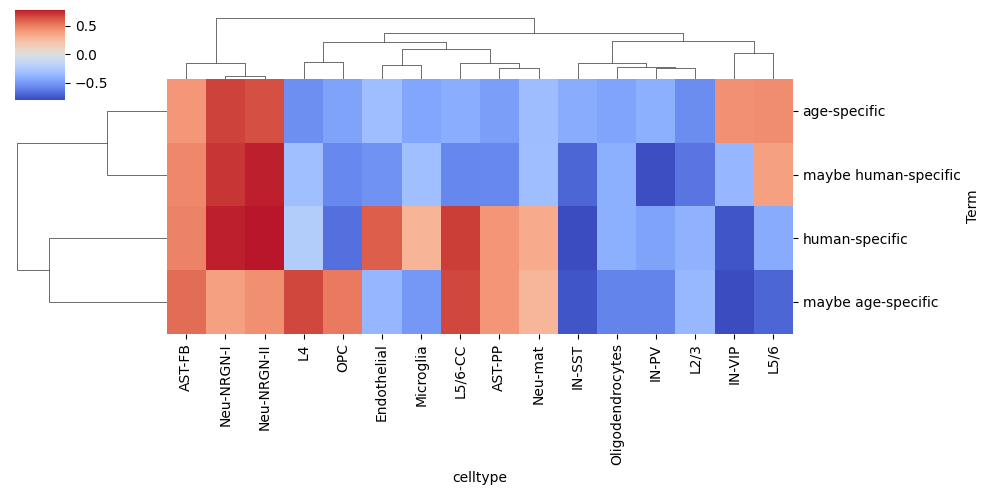

In [53]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

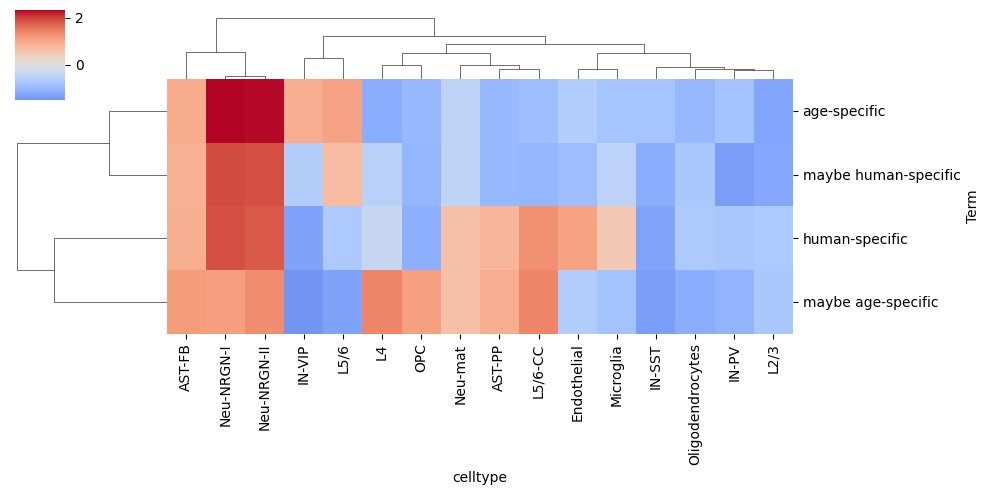

In [54]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

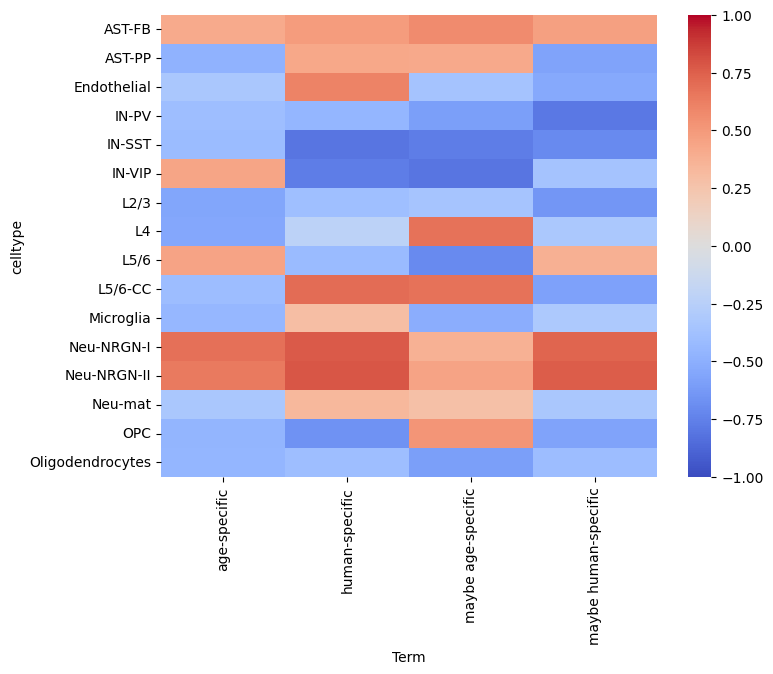

In [55]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Logreg

Specify DE test

In [56]:
key = 'logreg'

Run enrichment for genesets

In [57]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:08:31,638 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:32,386 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:33,054 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:33,724 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:34,436 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:35,116 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe human-specific  0.744364  1.582666  0.021898   0.05829   
1  prerank          age-specific  0.470987  1.277353  0.160317  0.260363   

  FWER p-val  Tag %  Gene %  \
0      0.045   6/10  13.45%   
1      0.354  11/26  17.47%   

                                          Lead_genes celltype  
0             NDUFB7;KIF21B;SCN3B;CHST10;CALR;MRPL51   AST-FB  
1  SYNGAP1;PCP4;ETFB;ASAP2;COTL1;ZBTB18;NDUFB10;C...   AST-FB

Process enrichment results

In [58]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe human-specific  0.744364  1.582666  0.021898   0.05829   
1  prerank          age-specific  0.470987  1.277353  0.160317  0.260363   

  FWER p-val  Tag %  Gene %  \
0      0.045   6/10  13.45%   
1      0.354  11/26  17.47%   

                                          Lead_genes celltype  -log10(FDR)  \
0             NDUFB7;KIF21B;SCN3B;CHST10;CALR;MRPL51   AST-FB     1.227017   
1  SYNGAP1;PCP4;ETFB;ASAP2;COTL1;ZBTB18;NDUFB10;C...   AST-FB     0.582756   

  direction  significant  
0  enriched  FDR >= 0.05  
1  enriched  FDR >= 0.05

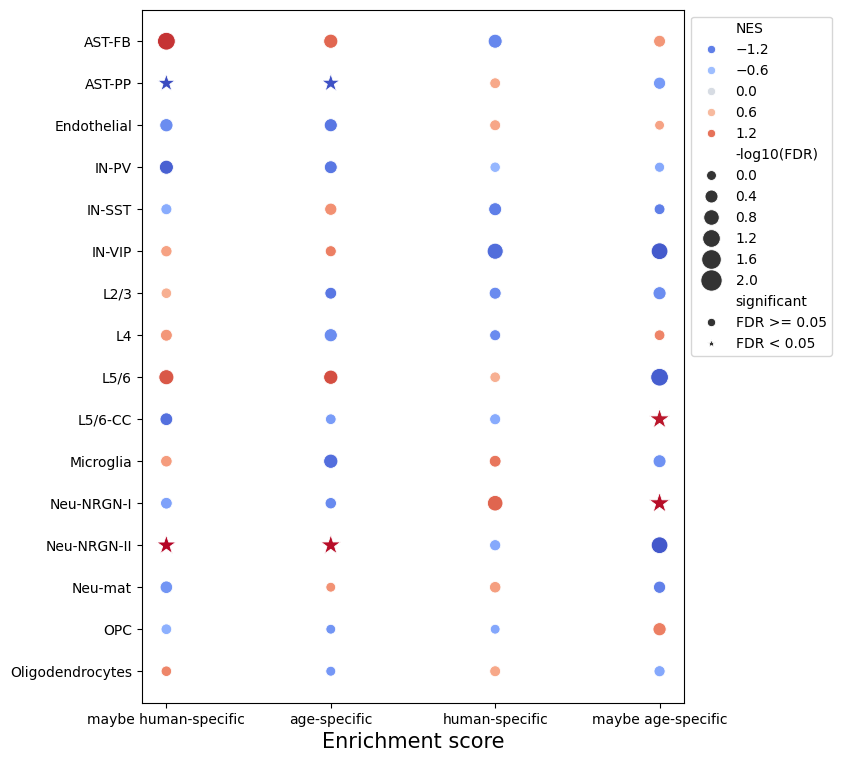

In [59]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

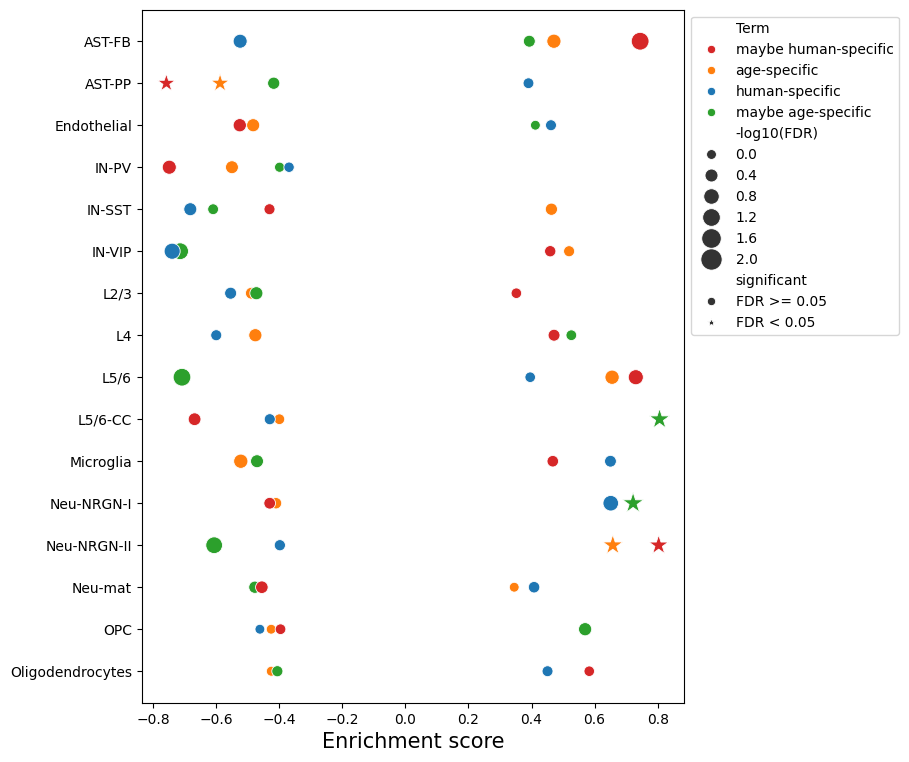

In [60]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

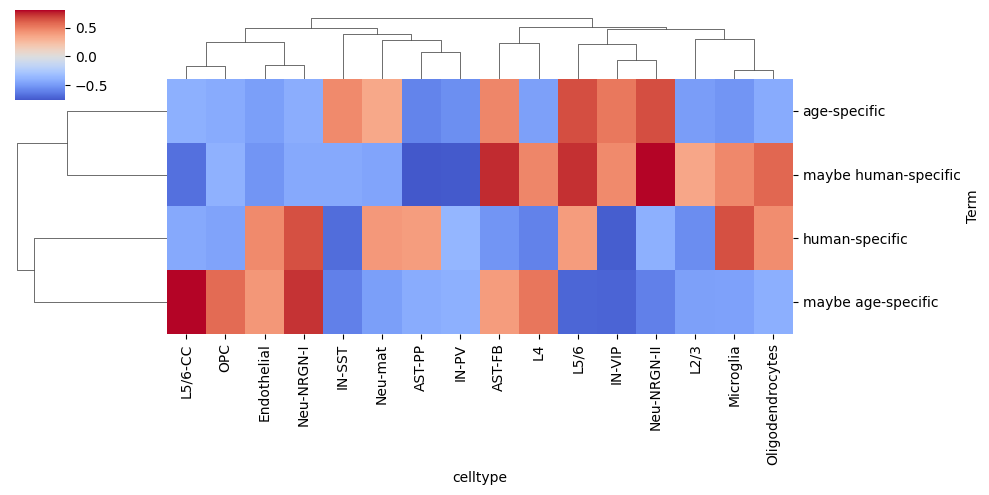

In [61]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

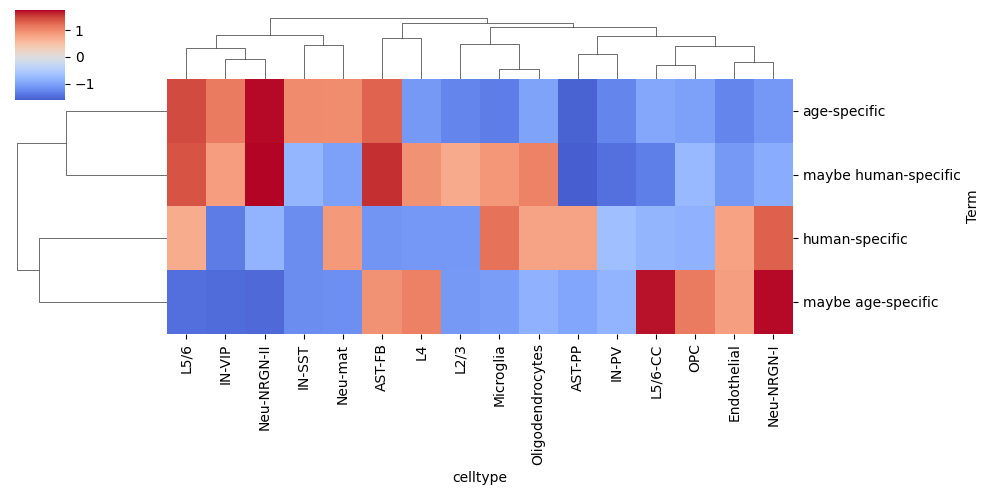

In [62]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

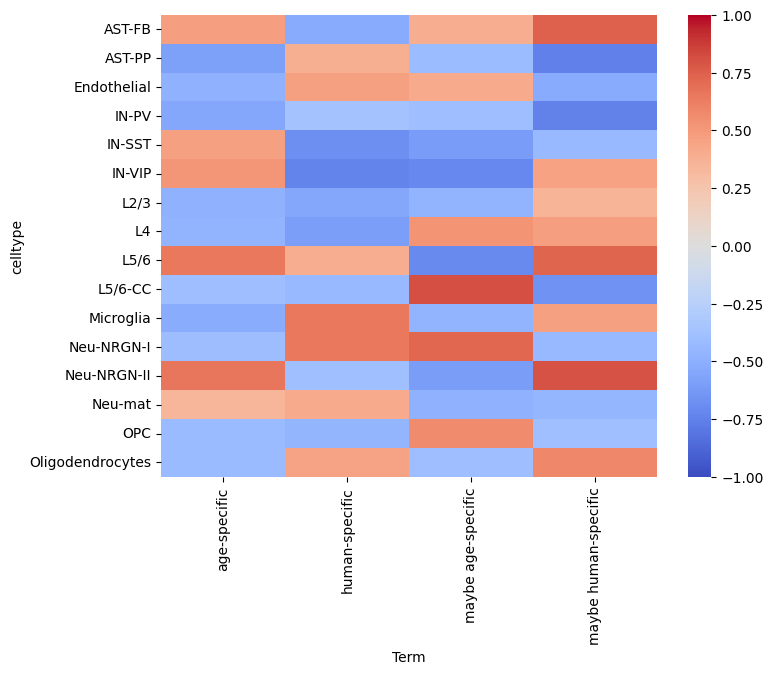

In [63]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR

Run enrichment for genesets

In [64]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True, 'weight': 0.5})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:08:42,421 [WARNING] Duplicated values found in preranked stats: 2.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:42,422 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:08:42,423 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:08:42,425 [INFO] 0004 gene_sets used for further statistical testing.....
2024-07-30 17:08:42,426 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:08:43,161 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:08:43,171 [WARNING] Duplicated values found in preranked stats: 1.29% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:08:43,171 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:08:43,173 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank        age-specific -0.384341 -1.084969  0.306122  0.732685   
1  prerank  maybe age-specific  0.450054  0.959839  0.527638       1.0   

  FWER p-val Tag % Gene %                                        Lead_genes  \
0   0.564189  8/26  5.43%  PDE1A;DLGAP4;GNAI1;ATP1A3;CX3CL1;NRXN2;ERC1;PPA1   
1      0.787  3/15  4.22%                                    MACF1;LHX2;ID2   

  celltype  
0   AST-FB  
1   AST-FB

Process enrichment results

In [65]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank        age-specific -0.384341 -1.084969  0.306122  0.732685   
1  prerank  maybe age-specific  0.450054  0.959839  0.527638       1.0   

  FWER p-val Tag % Gene %                                        Lead_genes  \
0   0.564189  8/26  5.43%  PDE1A;DLGAP4;GNAI1;ATP1A3;CX3CL1;NRXN2;ERC1;PPA1   
1      0.787  3/15  4.22%                                    MACF1;LHX2;ID2   

  celltype  -log10(FDR) direction  significant  
0   AST-FB     0.134490  depleted  FDR >= 0.05  
1   AST-FB    -0.000434  enriched  FDR >= 0.05

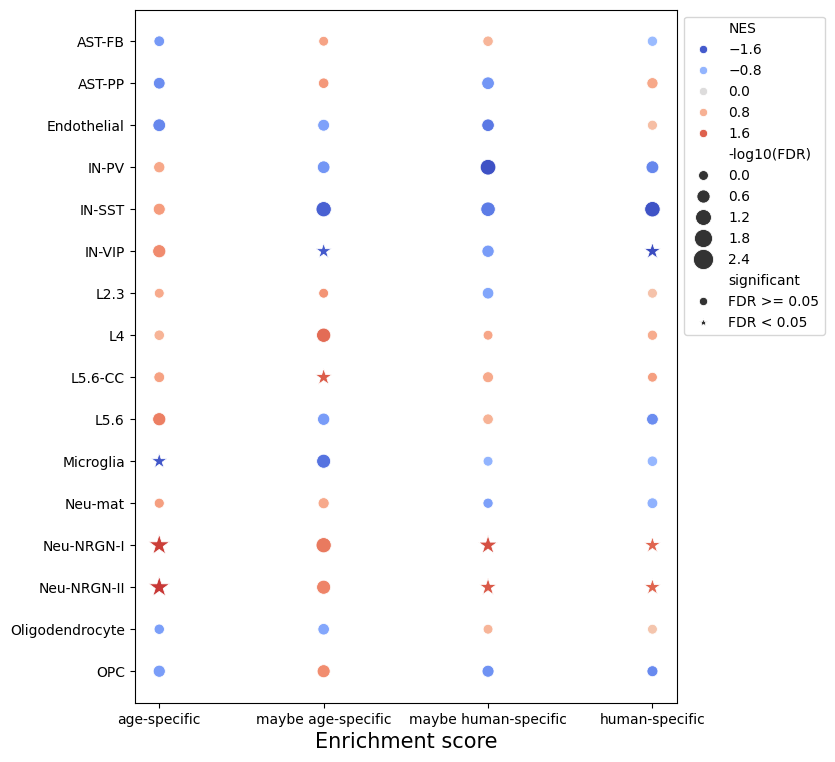

In [66]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    hue_norm=enrich_norm,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

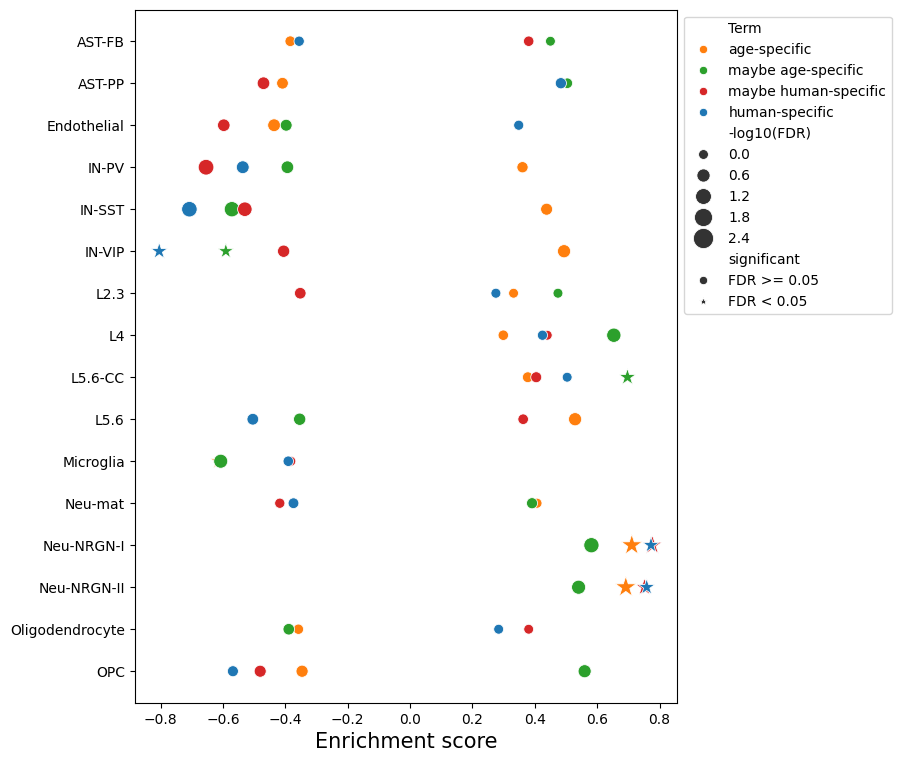

In [67]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

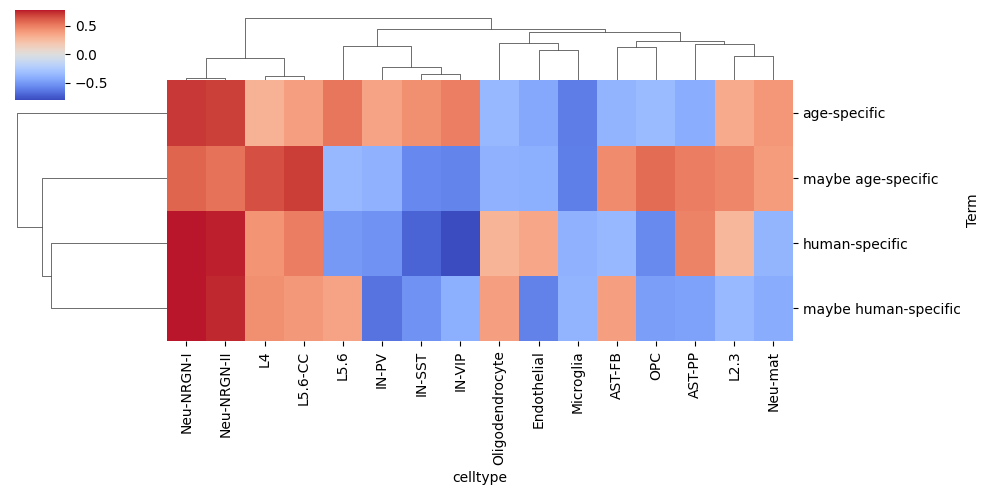

In [68]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

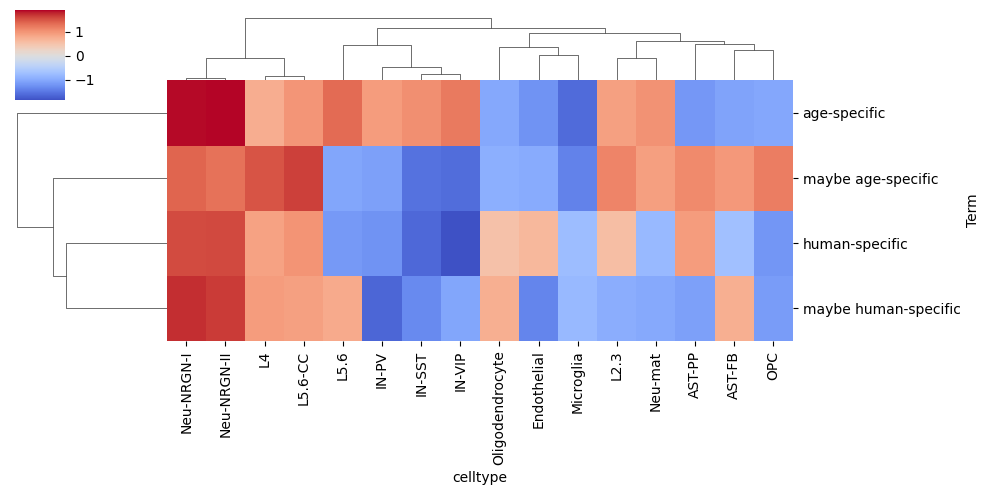

In [69]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

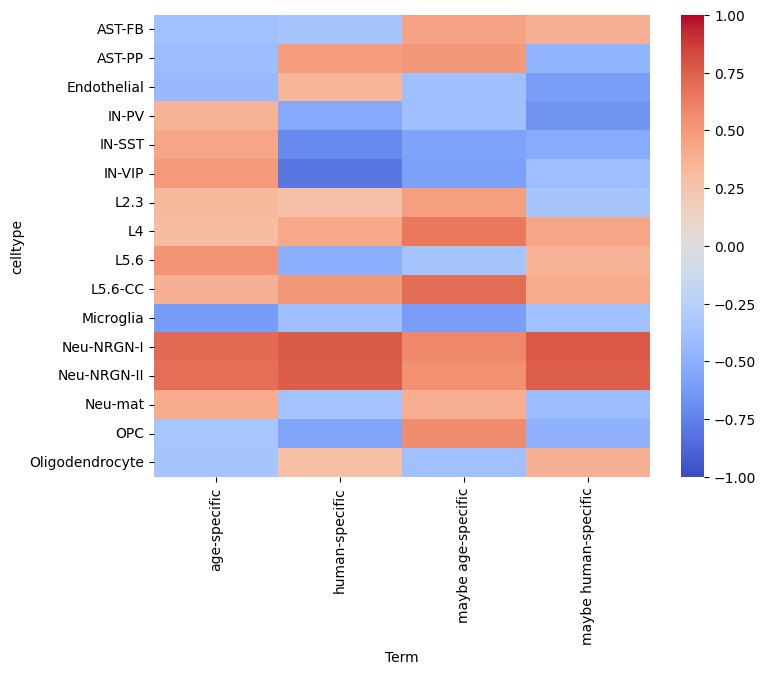

In [70]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR (logFC)

Run enrichment for genesets

In [71]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='logFC', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:08:54,960 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:08:54,965 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:08:54,967 [INFO] 0004 gene_sets used for further statistical testing.....
2024-07-30 17:08:54,968 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:08:55,674 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:08:55,682 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:08:55,684 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:08:55,685 [INFO] 0004 gene_sets used for further statistical testing.....
2024-07-30 17:08:55,685 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:08:56,465 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:08:56,476 [INFO] Parsing data files for GSEA............................

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank    maybe age-specific  0.342615  0.920034  0.569161  0.568169   
1  prerank  maybe human-specific -0.384567 -0.880334  0.611012       1.0   

  FWER p-val Tag %  Gene %            Lead_genes celltype  
0      0.686  3/15   7.82%        LHX2;ID2;MACF1   AST-FB  
1   0.859794  4/11  19.63%  MAZ;RGS2;NUAK1;SCN3B   AST-FB

Process enrichment results

In [72]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank    maybe age-specific  0.342615  0.920034  0.569161  0.568169   
1  prerank  maybe human-specific -0.384567 -0.880334  0.611012       1.0   

  FWER p-val Tag %  Gene %            Lead_genes celltype  -log10(FDR)  \
0      0.686  3/15   7.82%        LHX2;ID2;MACF1   AST-FB     0.244759   
1   0.859794  4/11  19.63%  MAZ;RGS2;NUAK1;SCN3B   AST-FB    -0.000434   

  direction  significant  
0  enriched  FDR >= 0.05  
1  depleted  FDR >= 0.05

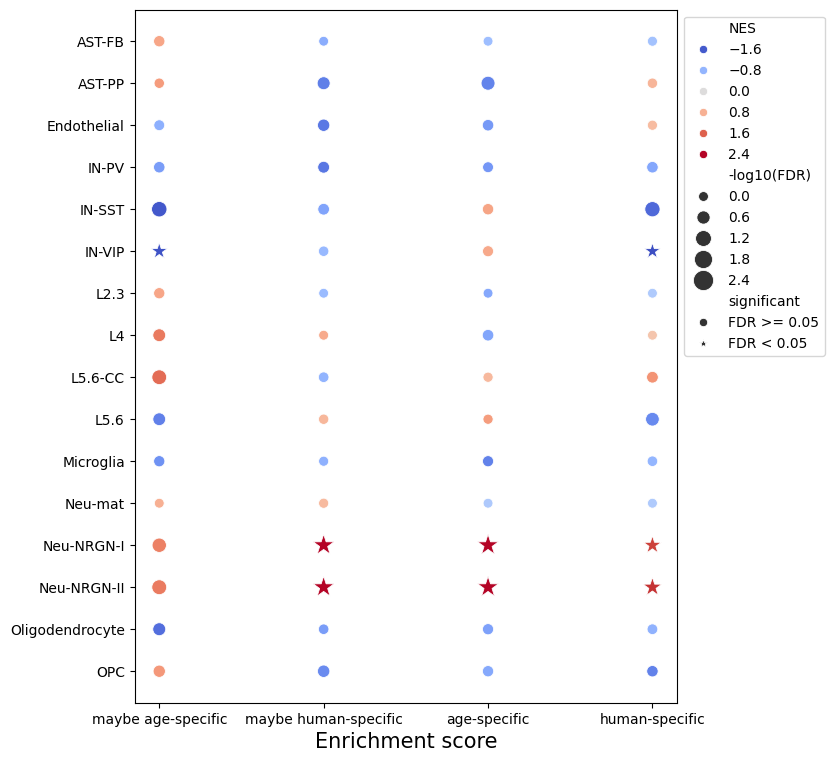

In [73]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    hue_norm=enrich_norm,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

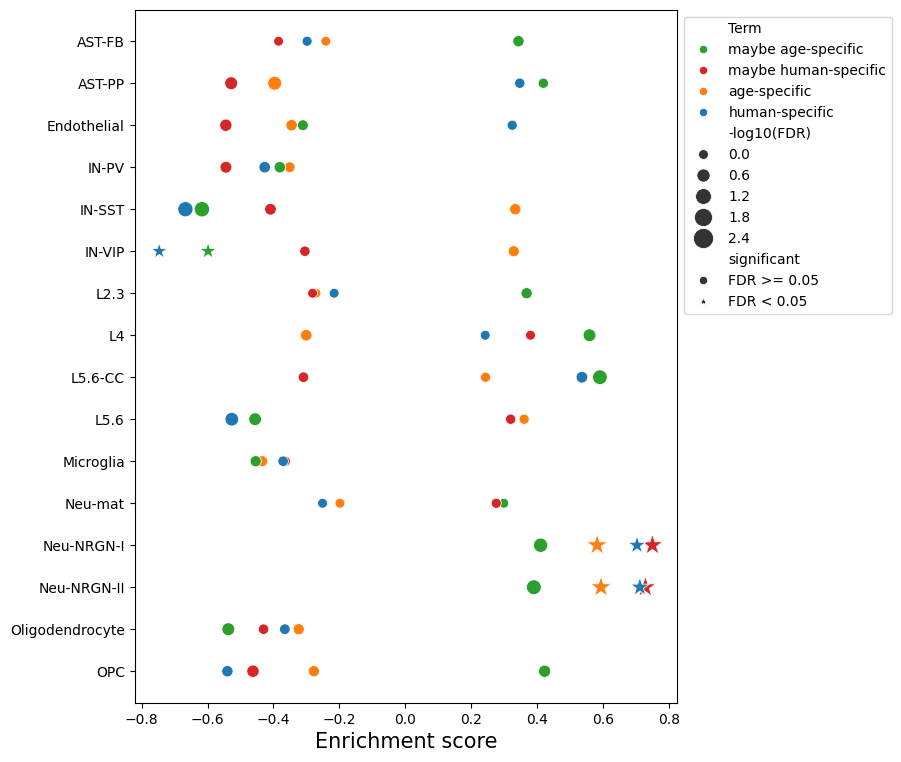

In [74]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

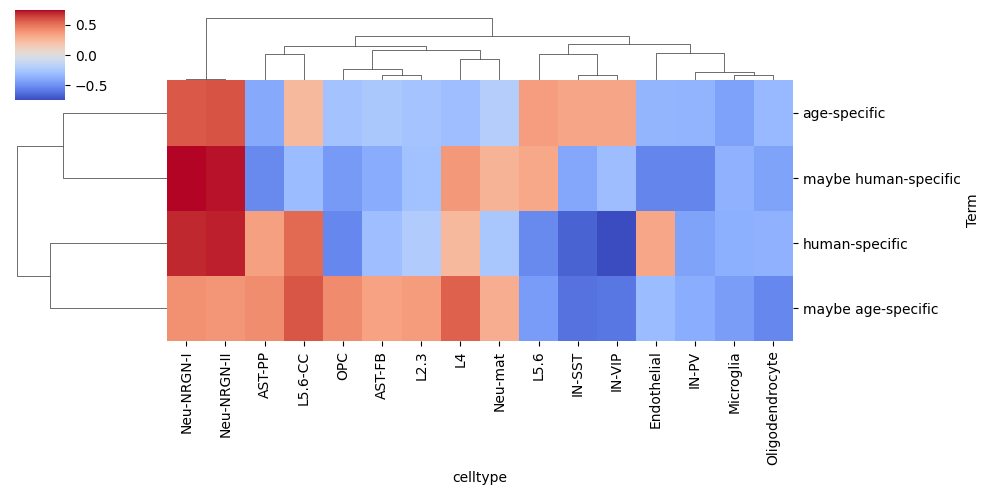

In [75]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

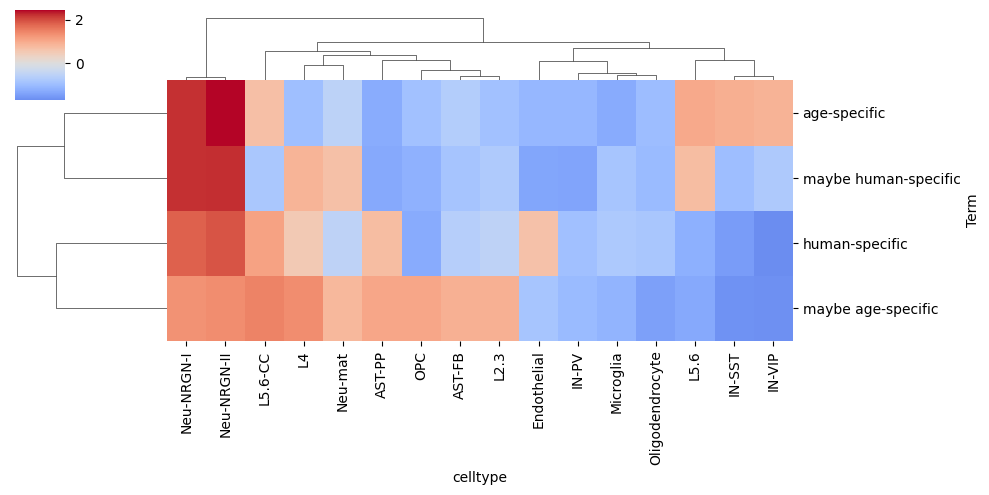

In [76]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

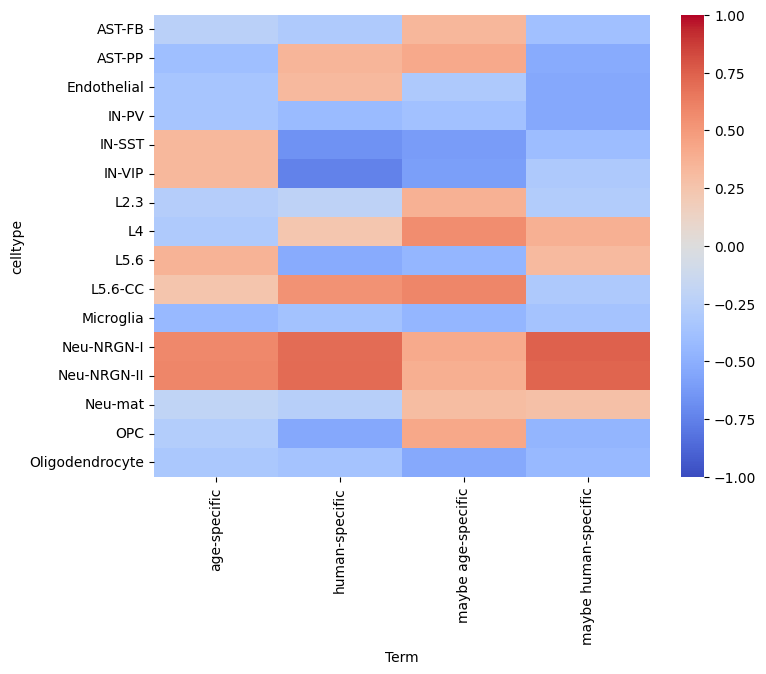

In [77]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Gene visualization

Calculate average normalized expression

In [78]:
for cluster in gene_sets.keys():
    genes = scaled_adata.var_names.intersection(gene_sets[cluster])
    scaled_adata.obs[f'{cluster}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

cluster     sample  individual region  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24       Neu-NRGN-II  1823_BA24        1823    ACC   
AAACGGGCACCAGATT-1_1823_BA24              L5/6  1823_BA24        1823    ACC   
AAAGATGAGTCCAGGA-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   
AAAGATGTCTTGAGGT-1_1823_BA24               OPC  1823_BA24        1823    ACC   
AAAGCAAGTAATCACC-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   

                              age sex diagnosis Capbatch Seqbatch  \
cell                                                                
AAACCTGGTACGCACC-1_1823_BA24   15   M   Control      CB8      SB3   
AAACGGGCACCAGATT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGAGTCCAGGA-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGTCTTGAGGT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGCAAGTAATCACC-1_1823_BA24   15   M   Control      CB8      SB3   

                              post-mortem interval (hours)  \
cell                                                         
AAACCTGGTACGCACC-1_1823_BA24                            18   
AAACGGGCACCAGATT-1_1823_BA24                            18   
AAAGATGAGTCCAGGA-1_1823_BA24                            18   
AAAGATGTCTTGAGGT-1_1823_BA24                            18   
AAAGCAAGTAATCACC-1_1823_BA24                            18   

                              RNA Integrity Number  genes   UMIs  \
cell                                                               
AAACCTGGTACGCACC-1_1823_BA24                   7.0    622    774   
AAACGGGCACCAGATT-1_1823_BA24                   7.0   6926  24042   
AAAGATGAGTCCAGGA-1_1823_BA24                   7.0    624    830   
AAAGATGTCTTGAGGT-1_1823_BA24                   7.0   1192   1771   
AAAGCAAGTAATCACC-1_1823_BA24                   7.0    691    895   

                              RNA mitochondr. percent  RNA ribosomal percent  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24                 2.454780               1.421189   
AAACGGGCACCAGATT-1_1823_BA24                 0.445055               0.428417   
AAAGATGAGTCCAGGA-1_1823_BA24                 0.240964               0.722892   
AAAGATGTCTTGAGGT-1_1823_BA24                 0.225861               1.806889   
AAAGCAAGTAATCACC-1_1823_BA24                 0.558659               0.670391   

                              All HS genes  age-specific_scaled  \
cell                                                              
AAACCTGGTACGCACC-1_1823_BA24      0.096139             0.044794   
AAACGGGCACCAGATT-1_1823_BA24      0.393796             0.370995   
AAAGATGAGTCCAGGA-1_1823_BA24     -0.107555            -0.209721   
AAAGATGTCTTGAGGT-1_1823_BA24     -0.023152            -0.008599   
AAAGCAAGTAATCACC-1_1823_BA24     -0.109846            -0.324078   

                              maybe age-specific_scaled  \
cell                                                      
AAACCTGGTACGCACC-1_1823_BA24                   0.009079   
AAACGGGCACCAGATT-1_1823_BA24                   0.404136   
AAAGATGAGTCCAGGA-1_1823_BA24                  -0.137062   
AAAGATGTCTTGAGGT-1_1823_BA24                  -0.022424   
AAAGCAAGTAATCACC-1_1823_BA24                  -0.114486   

                              maybe human-specific_scaled  \
cell                                                        
AAACCTGGTACGCACC-1_1823_BA24                     0.631965   
AAACGGGCACCAGATT-1_1823_BA24                     0.368279   
AAAGATGAGTCCAGGA-1_1823_BA24                     0.298023   
AAAGATGTCTTGAGGT-1_1823_BA24                    -0.364175   
AAAGCAAGTAATCACC-1_1823_BA24                     0.141202   

                              human-specific_scaled  
cell                                                 
AAACCTGGTACGCACC-1_1823_BA24              -0.255659  
AAACGGGCACCAGATT-1_1823_BA24               0.47

Vusualize

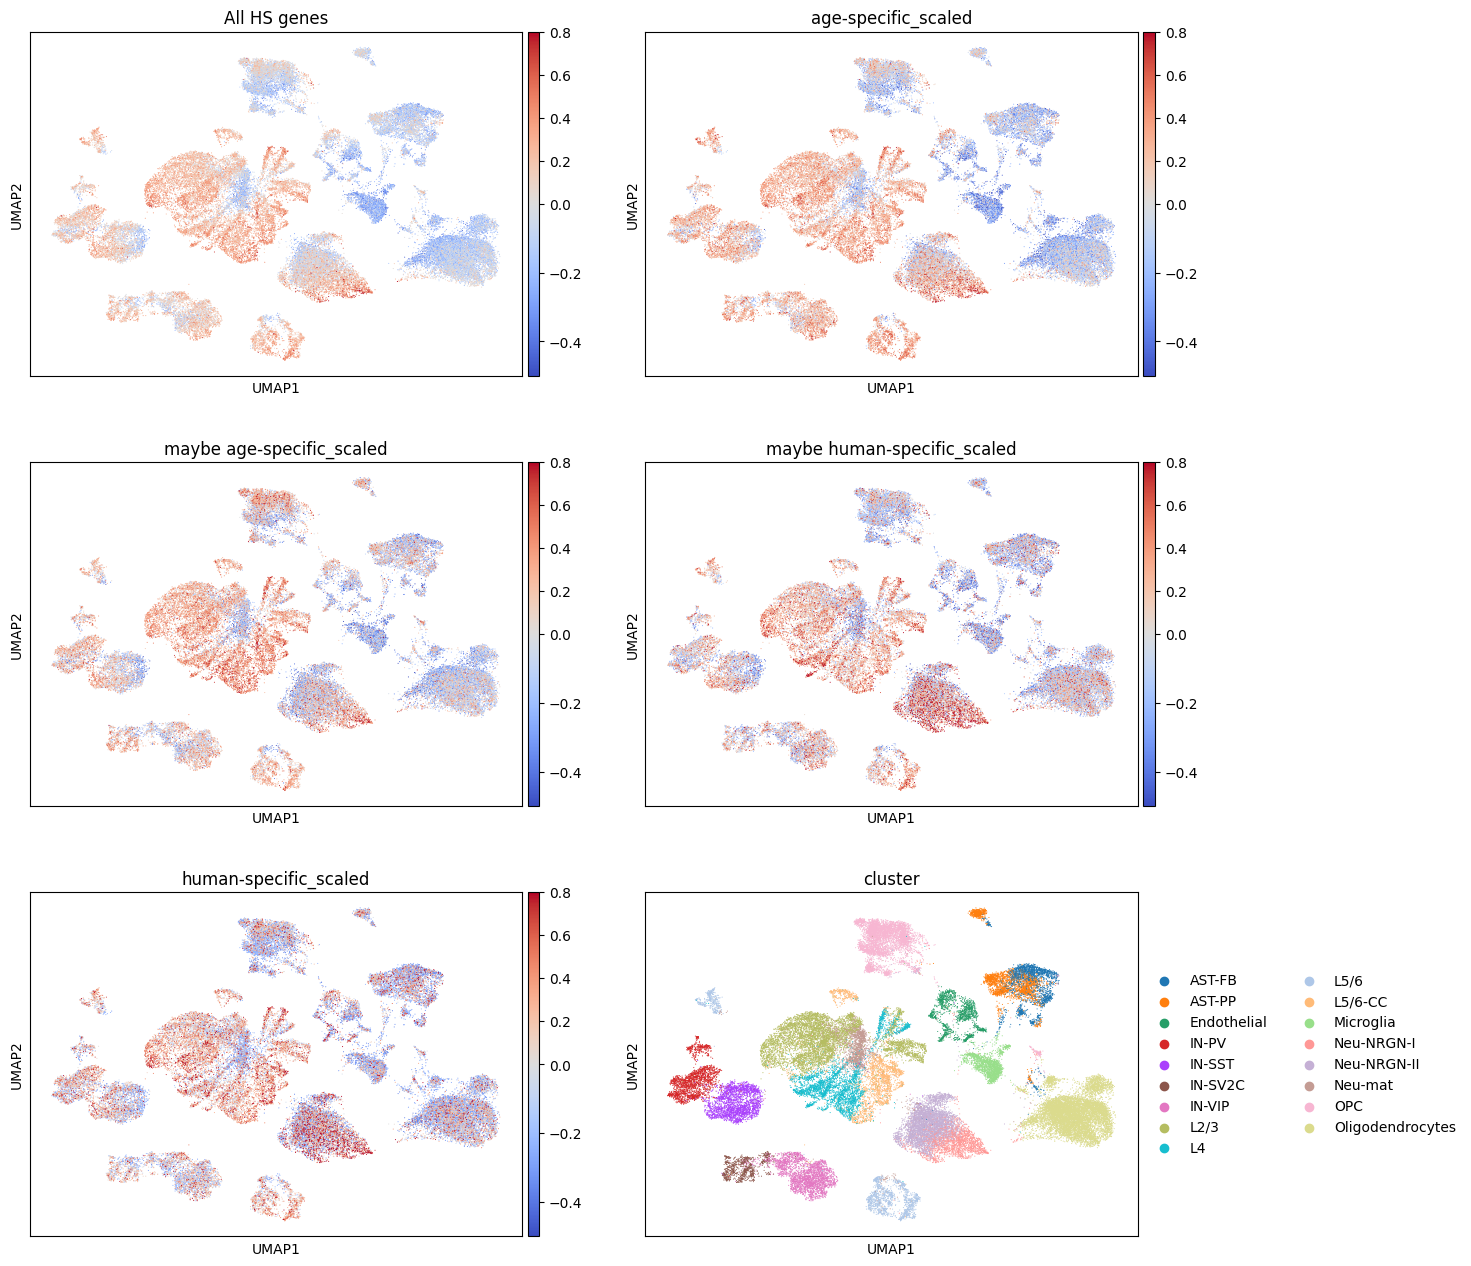

In [79]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.8, vmin=-0.5)
color = [
    'All HS genes', 
    'age-specific_scaled', 
    'maybe age-specific_scaled', 
    'maybe human-specific_scaled', 
    'human-specific_scaled', 
    'cluster'
    ]

sc.pl.umap(scaled_adata, color=color, cmap=cmap, norm=norm, ncols=2)

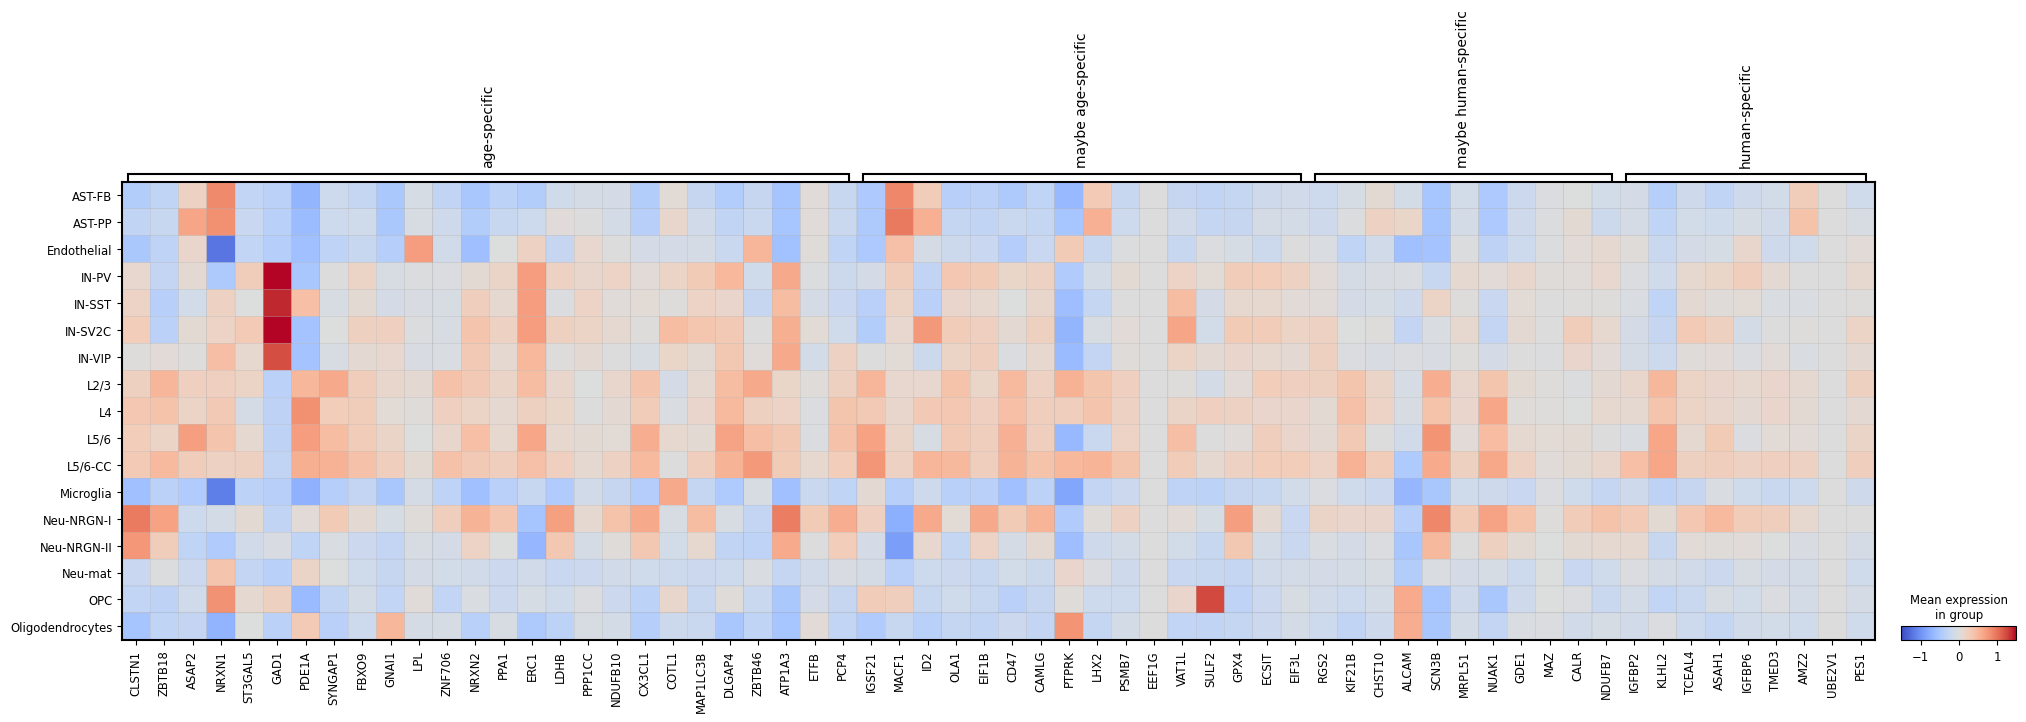

In [80]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

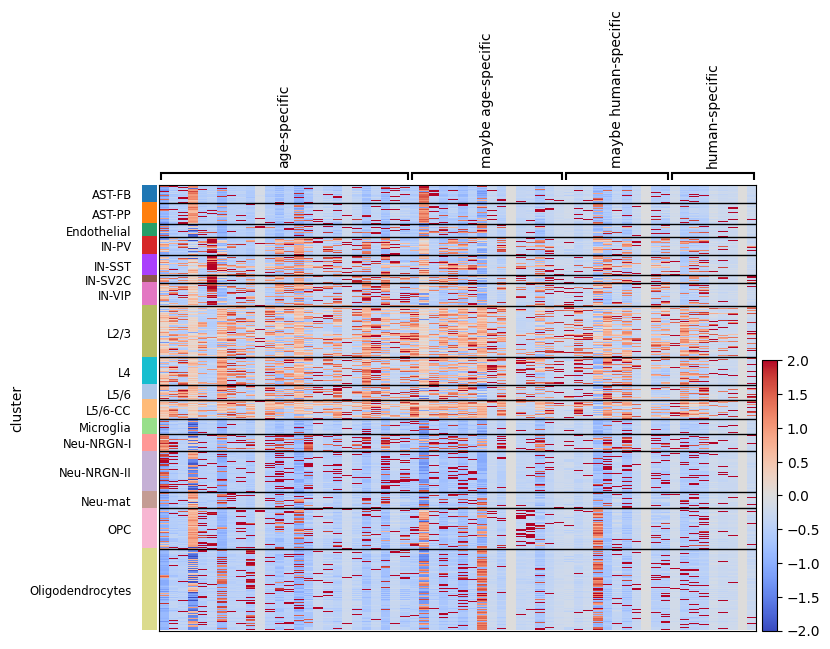

In [81]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

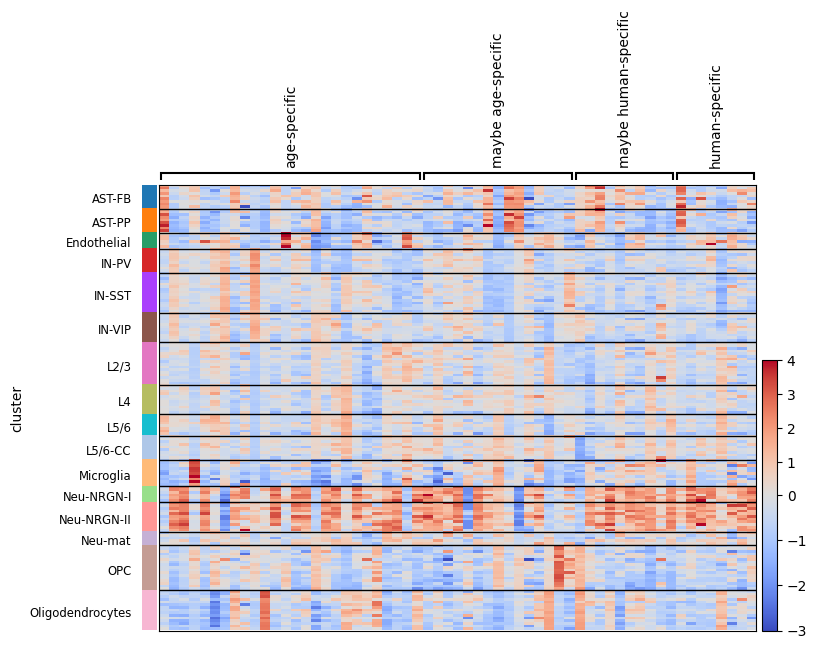

In [82]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='cluster', cmap='coolwarm', vcenter=0, vmin=-3, vmax=4)

## Enrich for clusters

In [83]:
gene_sets = dict()
for label in cluster_groups.label.unique():
  gene_sets[f'cluster{label}'] = cluster_groups[cluster_groups.label == label].index.to_list()

### T-test

Specify DE test

In [84]:
key = 't-test'

Run enrichment for genesets

In [85]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:09:10,975 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:12,555 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:13,312 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:14,061 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:14,779 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:15,520 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster5  0.742121   1.61972  0.025063  0.063015       0.05   4/8   
1  prerank  cluster1  0.558646  1.401959  0.118388  0.162479      0.234  8/13   

   Gene %                                         Lead_genes celltype  
0   8.42%                             LHX2;ETFB;CHST10;COTL1   AST-FB  
1  21.73%  ASAP2;AMZ2;LDHB;NDUFB10;ECSIT;NDUFB7;MRPL51;TC...   AST-FB

Process enrichment results

In [86]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster5  0.742121   1.61972  0.025063  0.063015       0.05   4/8   
1  prerank  cluster1  0.558646  1.401959  0.118388  0.162479      0.234  8/13   

   Gene %                                         Lead_genes celltype  \
0   8.42%                             LHX2;ETFB;CHST10;COTL1   AST-FB   
1  21.73%  ASAP2;AMZ2;LDHB;NDUFB10;ECSIT;NDUFB7;MRPL51;TC...   AST-FB   

   -log10(FDR) direction  significant  
0     1.193719  enriched  FDR >= 0.05  
1     0.786537  enriched  FDR >= 0.05

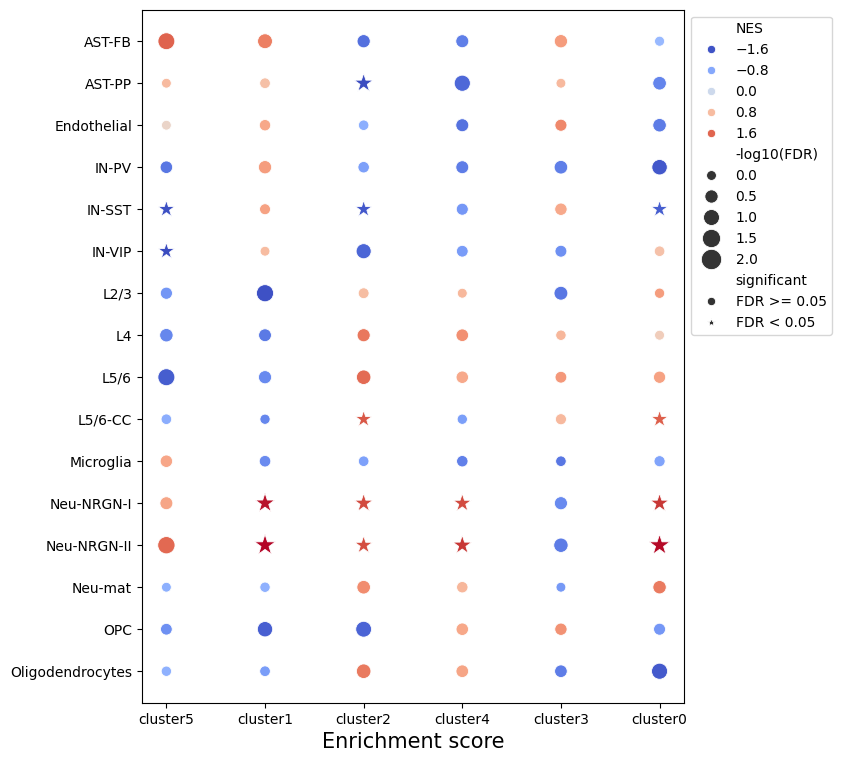

In [87]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_40924\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


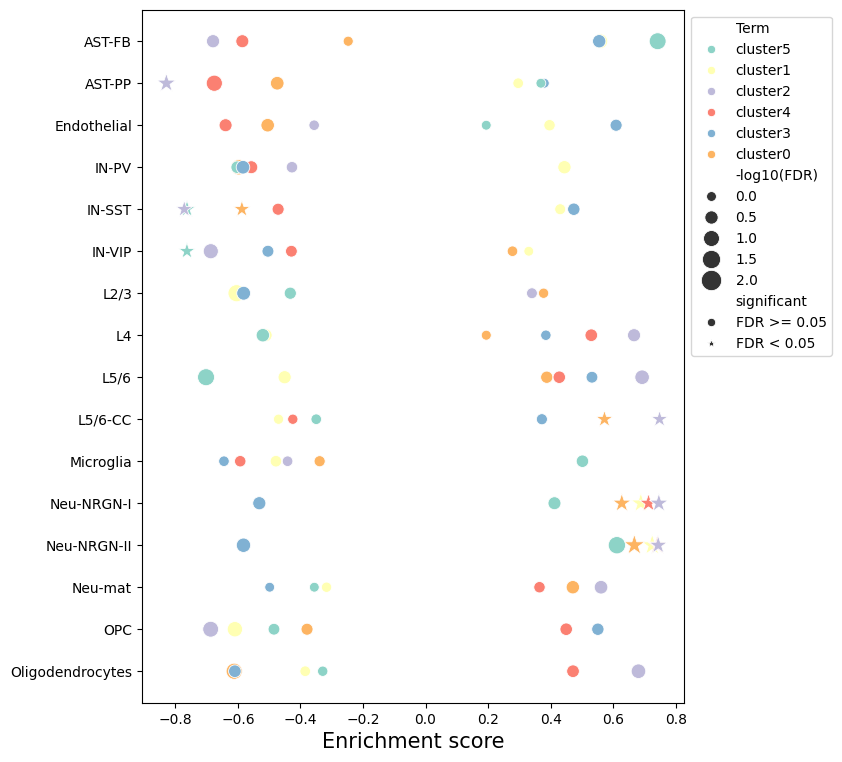

In [88]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

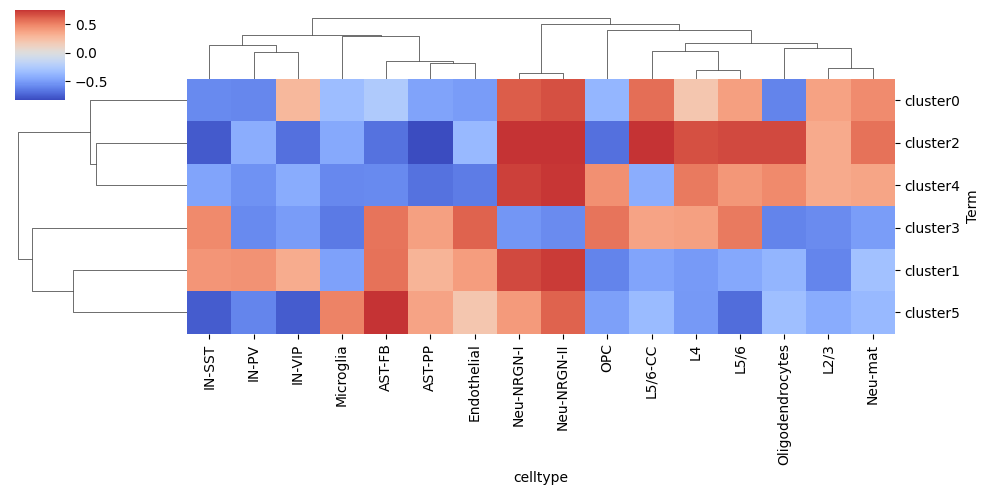

In [89]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

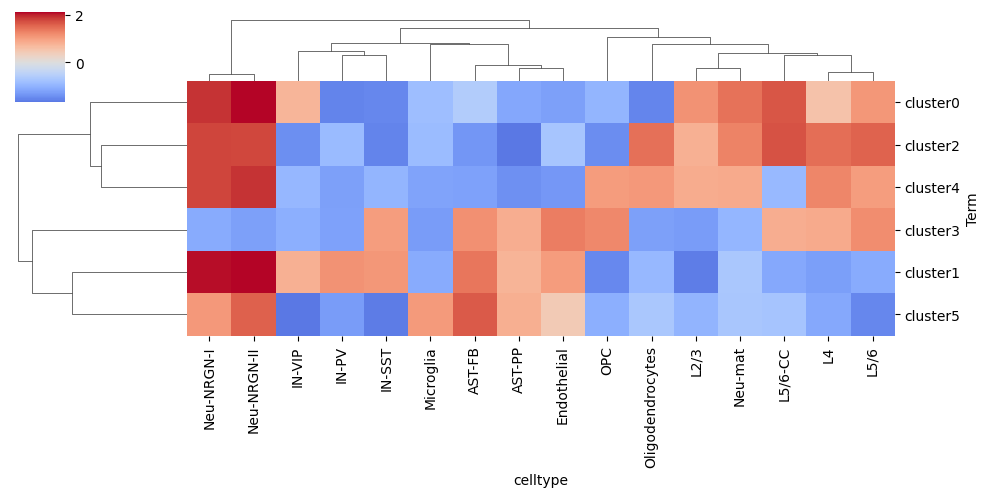

In [90]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

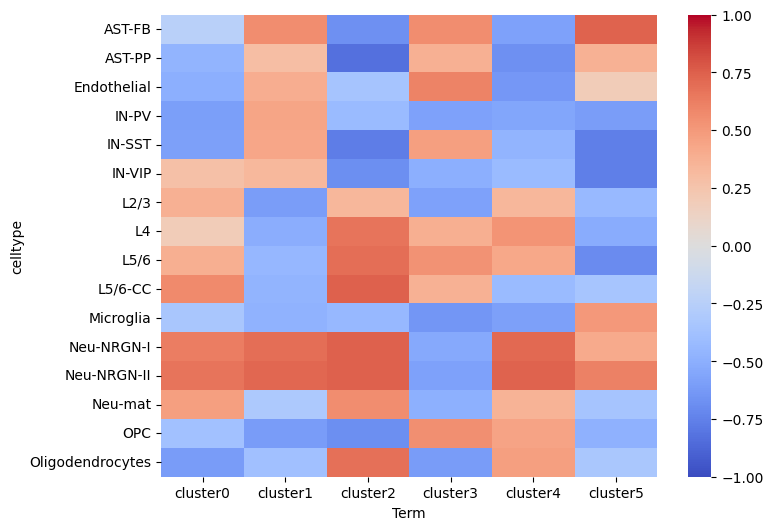

In [91]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Wilcoxon

Specify DE test

In [92]:
key = 'wilcoxon'

Run enrichment for genesets

In [93]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:09:23,541 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:24,316 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:25,066 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:25,840 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:26,629 [WARNING] Duplicated values found in preranked stats: 0.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:27,387 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster5  0.828997  1.480622  0.043597  0.110541      0.075   4/8   
1  prerank  cluster1  0.673537  1.301122  0.159509  0.249067      0.309  8/13   

   Gene %                                         Lead_genes celltype  
0  10.29%                             LHX2;CHST10;ETFB;COTL1   AST-FB  
1  25.39%  AMZ2;ASAP2;LDHB;NDUFB10;NDUFB7;ECSIT;TCEAL4;MR...   AST-FB

Process enrichment results

In [94]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster5  0.828997  1.480622  0.043597  0.110541      0.075   4/8   
1  prerank  cluster1  0.673537  1.301122  0.159509  0.249067      0.309  8/13   

   Gene %                                         Lead_genes celltype  \
0  10.29%                             LHX2;CHST10;ETFB;COTL1   AST-FB   
1  25.39%  AMZ2;ASAP2;LDHB;NDUFB10;NDUFB7;ECSIT;TCEAL4;MR...   AST-FB   

   -log10(FDR) direction  significant  
0     0.952565  enriched  FDR >= 0.05  
1     0.601943  enriched  FDR >= 0.05

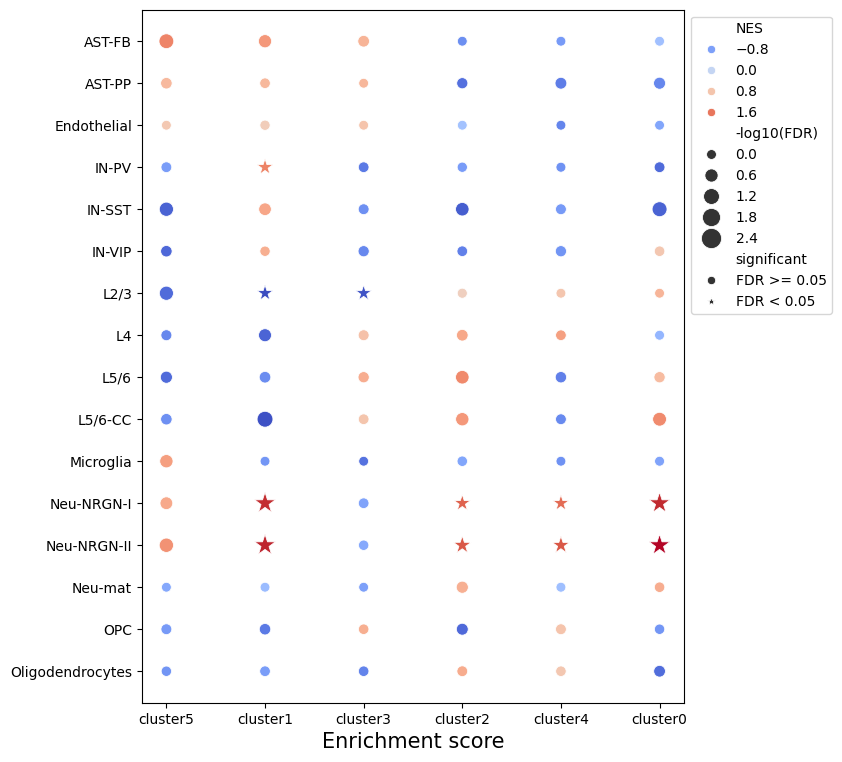

In [95]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_40924\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


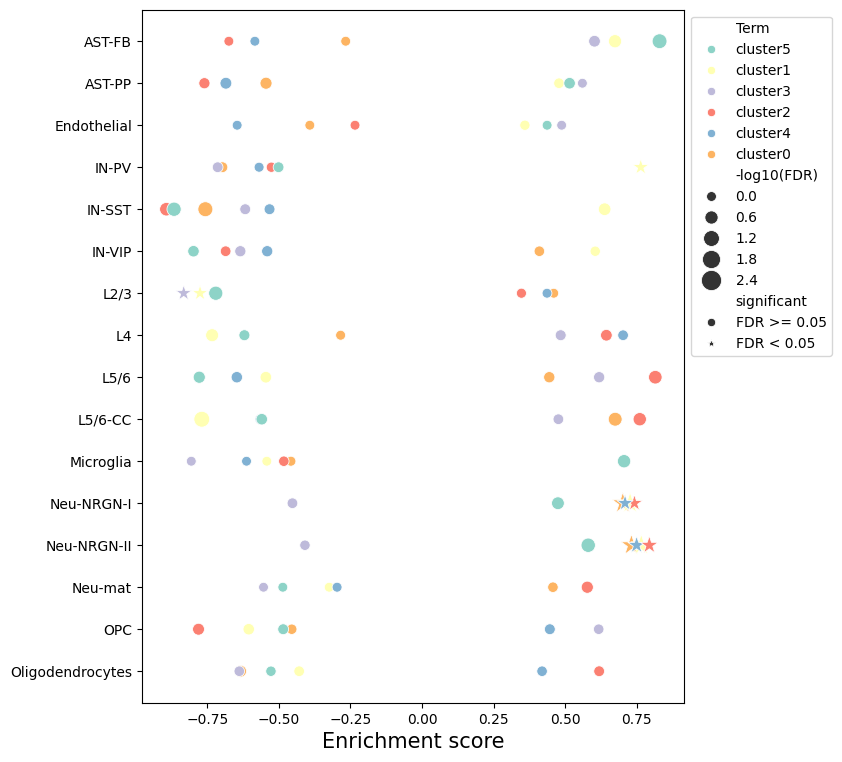

In [96]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

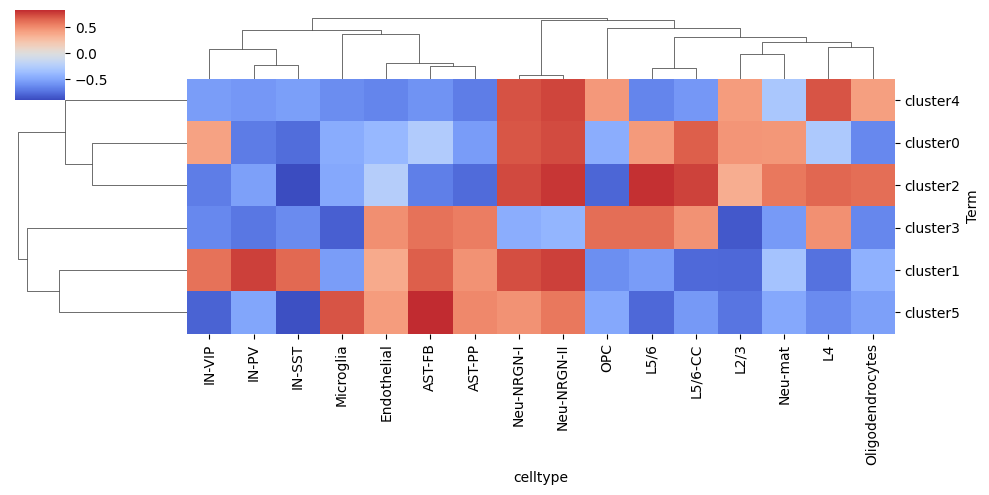

In [97]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

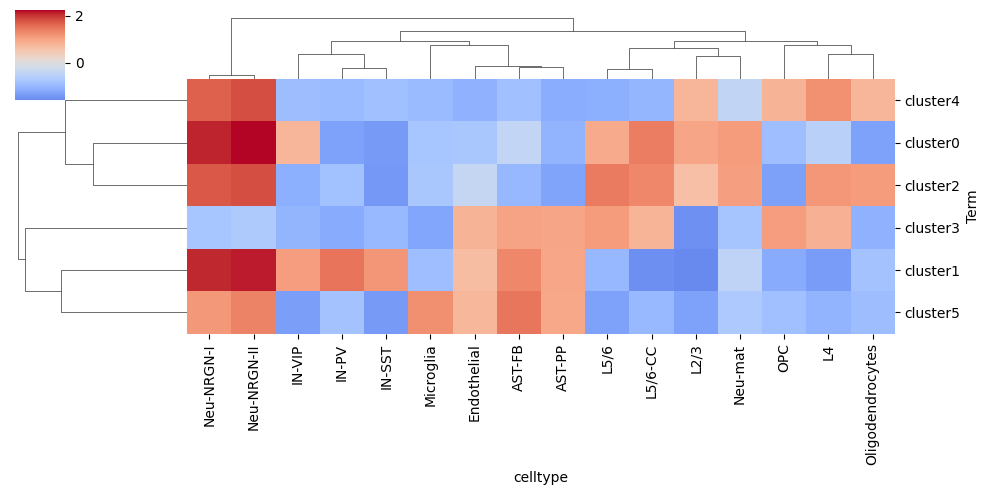

In [98]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

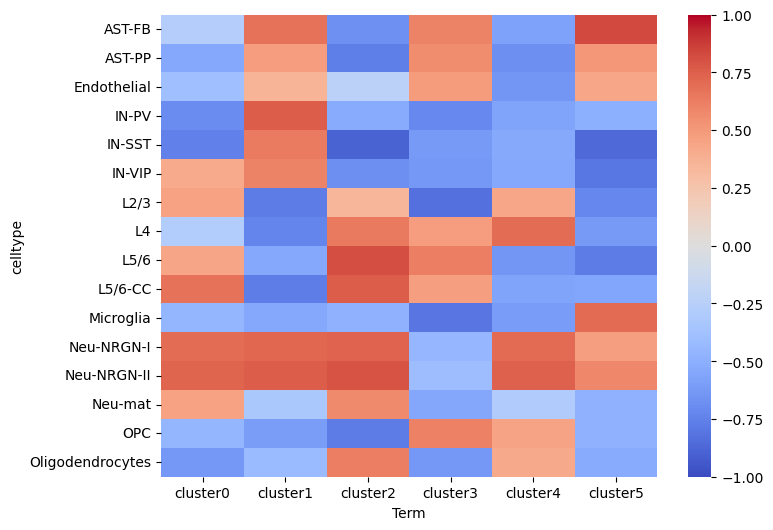

In [99]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Logreg

Specify DE test

In [100]:
key = 'logreg'

Run enrichment for genesets

In [101]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:09:38,572 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:39,320 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:40,051 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:40,769 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:41,540 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:42,330 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name      Term        ES      NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2   -0.8063 -1.67403  0.006438  0.021563   0.029046   5/7   
1  prerank  cluster1  0.674124  1.56573  0.025641  0.097561      0.078  9/13   

   Gene %                                         Lead_genes celltype  
0  15.80%                       KLHL2;PPA1;FBXO9;CX3CL1;OLA1   AST-FB  
1  19.63%  NDUFB7;ASAP2;GPX4;NDUFB10;MRPL51;AMZ2;LDHB;PSM...   AST-FB

Process enrichment results

In [102]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES      NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2   -0.8063 -1.67403  0.006438  0.021563   0.029046   5/7   
1  prerank  cluster1  0.674124  1.56573  0.025641  0.097561      0.078  9/13   

   Gene %                                         Lead_genes celltype  \
0  15.80%                       KLHL2;PPA1;FBXO9;CX3CL1;OLA1   AST-FB   
1  19.63%  NDUFB7;ASAP2;GPX4;NDUFB10;MRPL51;AMZ2;LDHB;PSM...   AST-FB   

   -log10(FDR) direction  significant  
0     1.646597  depleted   FDR < 0.05  
1     1.006295  enriched  FDR >= 0.05

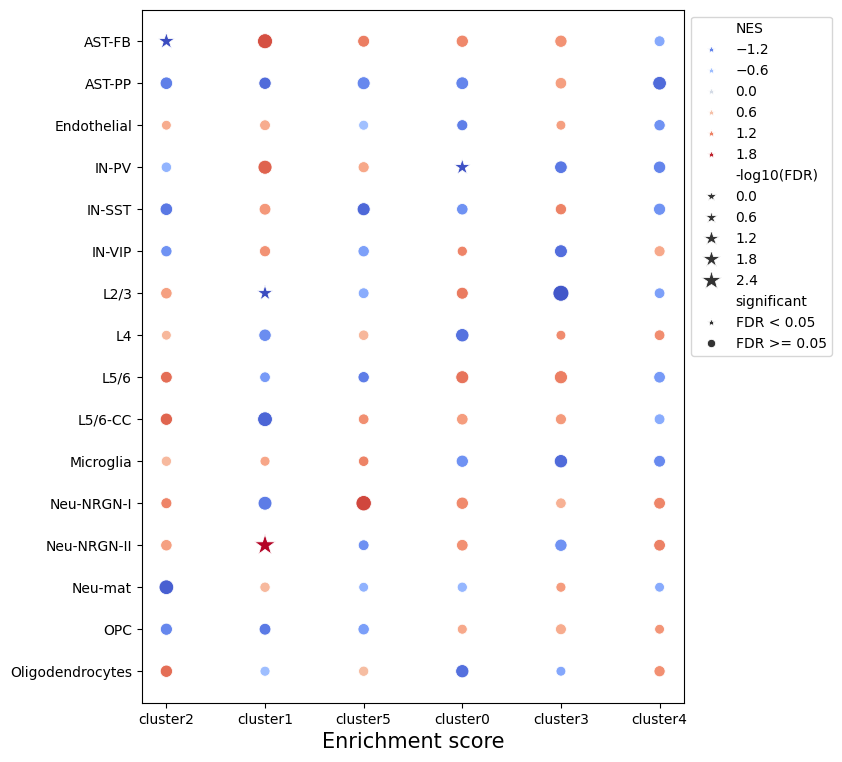

In [103]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_40924\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


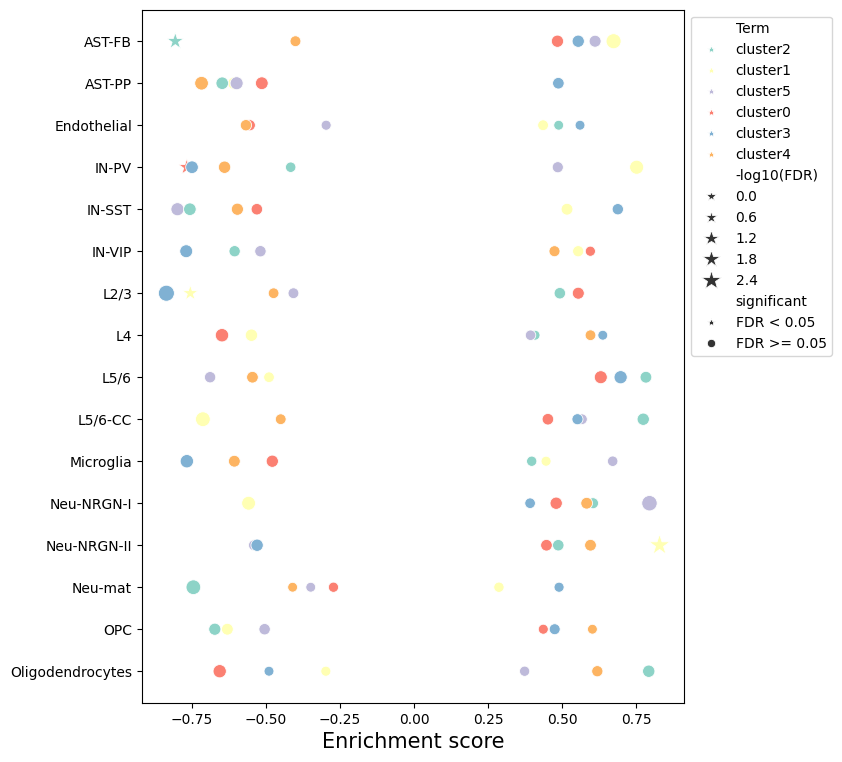

In [104]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

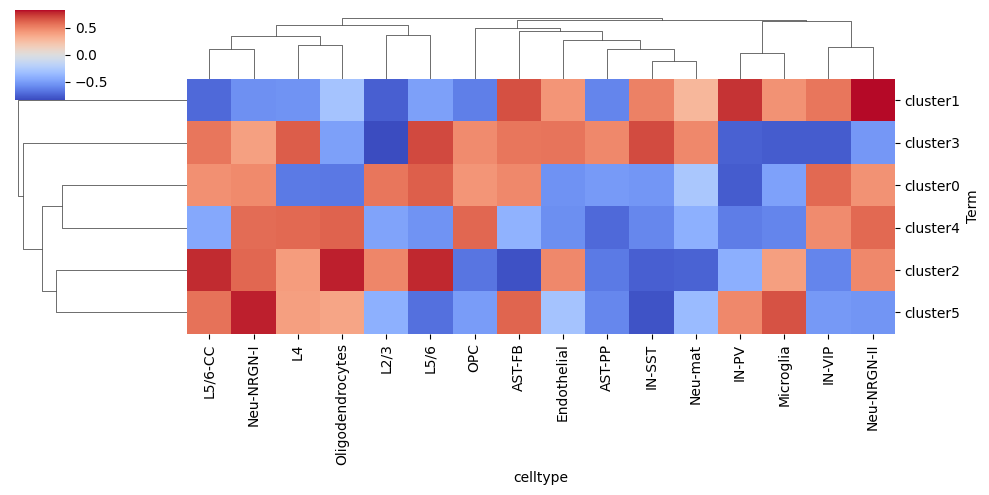

In [105]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

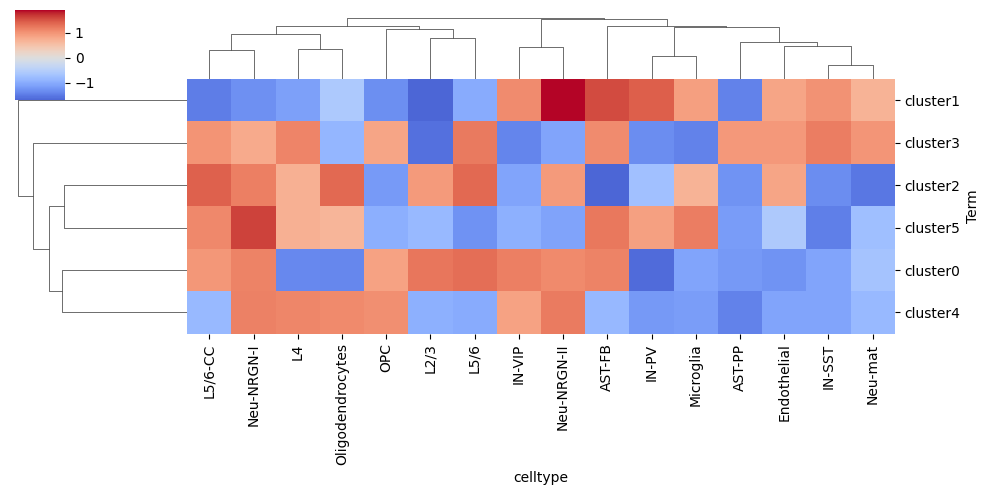

In [106]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

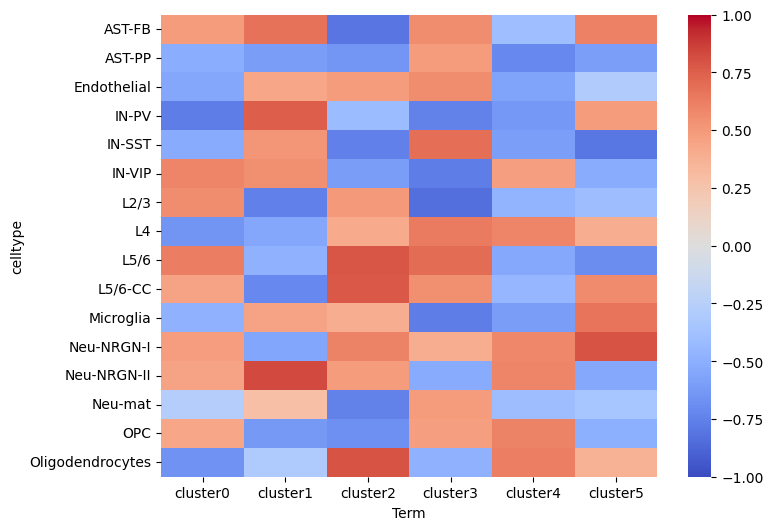

In [107]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR

Run enrichment for genesets

In [108]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True, 'weight': 0.5})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:09:50,019 [WARNING] Duplicated values found in preranked stats: 2.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:50,020 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:09:50,022 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:09:50,023 [INFO] 0006 gene_sets used for further statistical testing.....
2024-07-30 17:09:50,023 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:09:50,788 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:09:50,798 [WARNING] Duplicated values found in preranked stats: 1.29% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:09:50,799 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:09:50,800 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2 -0.896012 -1.765483       0.0   0.00569   0.005176   7/7   
1  prerank  cluster4 -0.679374 -1.395951   0.09607  0.144537    0.23499   6/8   

   Gene %                                Lead_genes celltype  
0  10.44%  NUAK1;KLHL2;GNAI1;OLA1;CX3CL1;PPA1;FBXO9   AST-FB  
1  19.97%     IGSF21;CD47;ATP1A3;PTPRK;CLSTN1;VAT1L   AST-FB

Process enrichment results

In [109]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2 -0.896012 -1.765483       0.0   0.00569   0.005176   7/7   
1  prerank  cluster4 -0.679374 -1.395951   0.09607  0.144537    0.23499   6/8   

   Gene %                                Lead_genes celltype  -log10(FDR)  \
0  10.44%  NUAK1;KLHL2;GNAI1;OLA1;CX3CL1;PPA1;FBXO9   AST-FB     2.174545   
1  19.97%     IGSF21;CD47;ATP1A3;PTPRK;CLSTN1;VAT1L   AST-FB     0.837026   

  direction  significant  
0  depleted   FDR < 0.05  
1  depleted  FDR >= 0.05

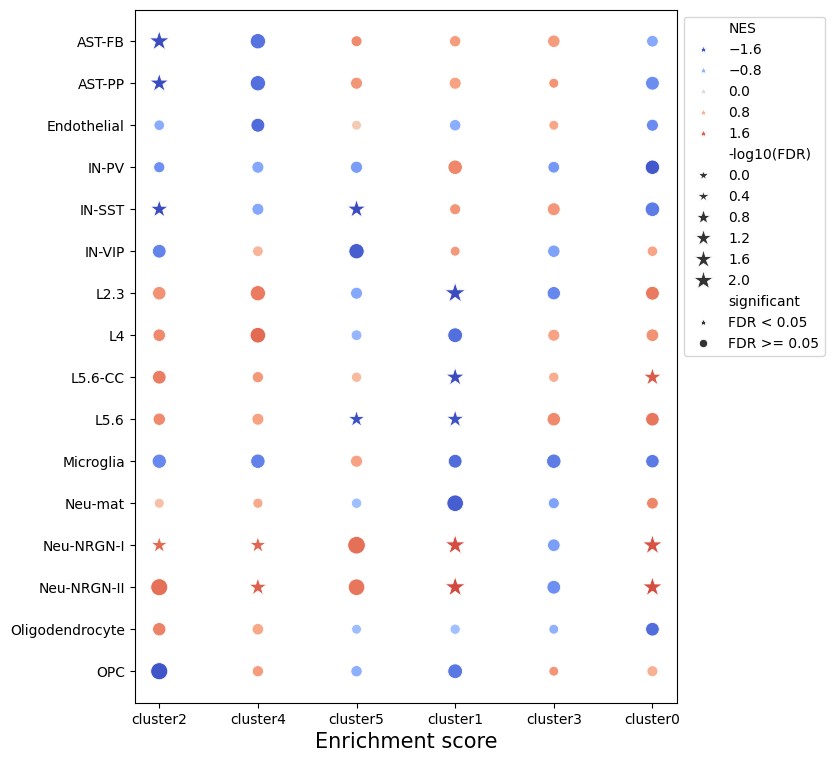

In [110]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    hue_norm=enrich_norm,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_40924\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


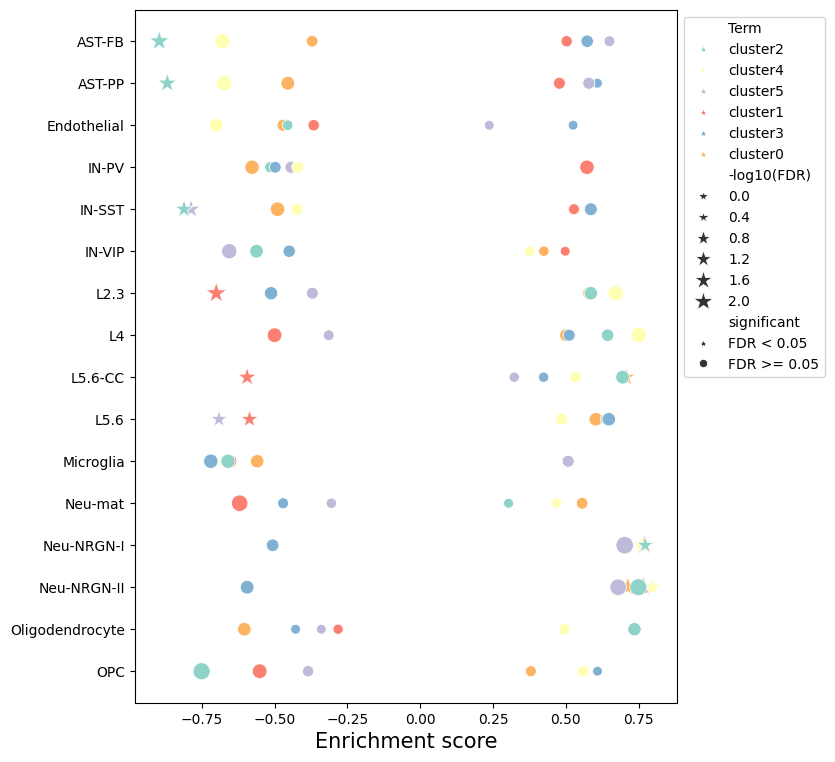

In [111]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

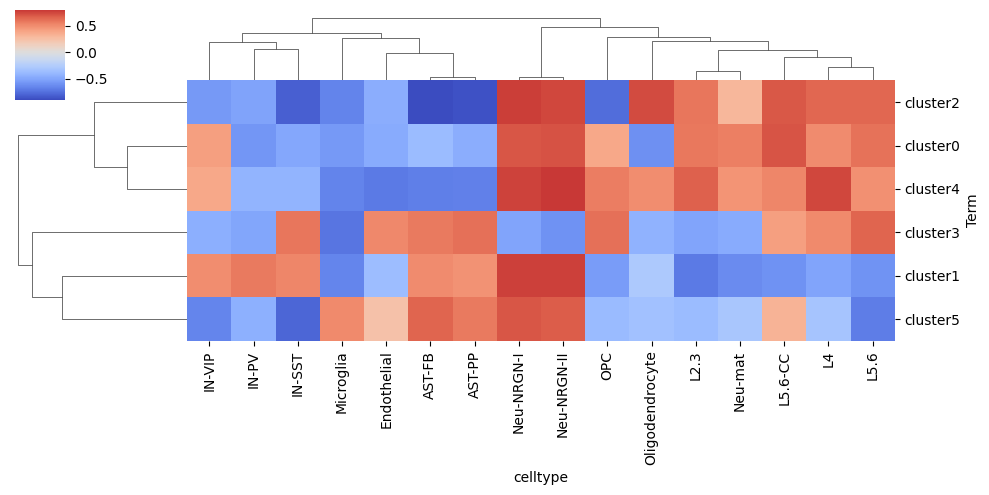

In [112]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

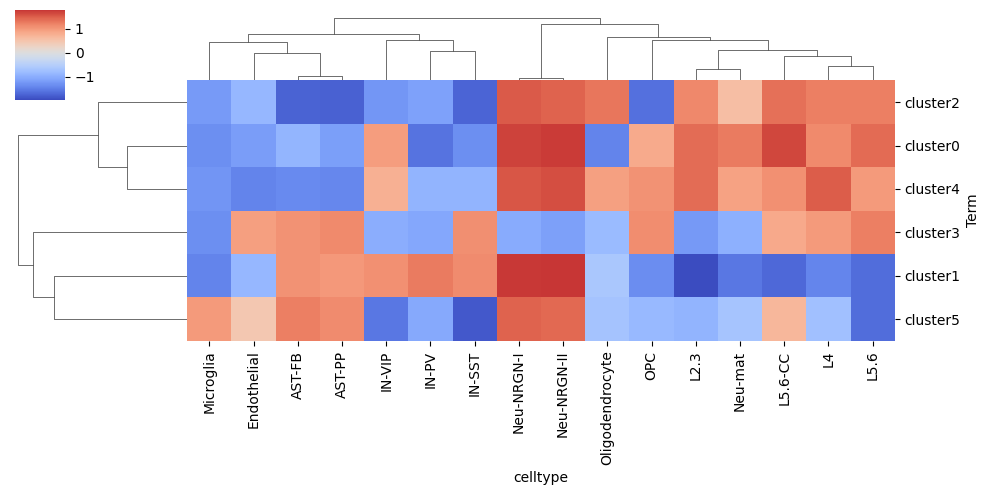

In [113]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

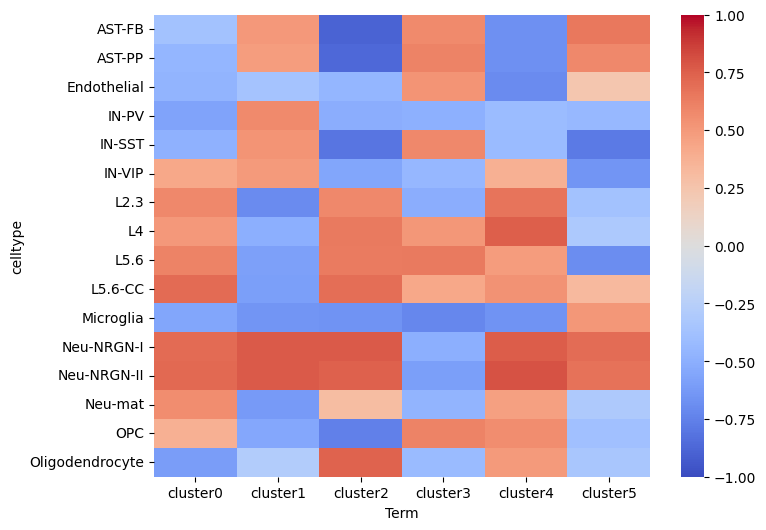

In [114]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR (logFC)

Run enrichment for genesets

In [115]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='logFC', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:10:03,538 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:10:03,541 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:10:03,543 [INFO] 0006 gene_sets used for further statistical testing.....
2024-07-30 17:10:03,544 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:10:04,313 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:10:04,327 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:10:04,332 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:10:04,333 [INFO] 0006 gene_sets used for further statistical testing.....
2024-07-30 17:10:04,334 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:10:05,098 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:10:05,109 [INFO] Parsing data files for GSEA............................

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2 -0.691807 -1.400282  0.082061  0.257219   0.268882   7/7   
1  prerank  cluster4 -0.592944  -1.28244  0.184669  0.269277   0.479355   5/8   

   Gene %                                Lead_genes celltype  
0  30.85%  CX3CL1;NUAK1;KLHL2;GNAI1;PPA1;FBXO9;OLA1   AST-FB  
1  25.62%            IGSF21;ATP1A3;CD47;VAT1L;PTPRK   AST-FB

Process enrichment results

In [116]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2 -0.691807 -1.400282  0.082061  0.257219   0.268882   7/7   
1  prerank  cluster4 -0.592944  -1.28244  0.184669  0.269277   0.479355   5/8   

   Gene %                                Lead_genes celltype  -log10(FDR)  \
0  30.85%  CX3CL1;NUAK1;KLHL2;GNAI1;PPA1;FBXO9;OLA1   AST-FB     0.588011   
1  25.62%            IGSF21;ATP1A3;CD47;VAT1L;PTPRK   AST-FB     0.568192   

  direction  significant  
0  depleted  FDR >= 0.05  
1  depleted  FDR >= 0.05

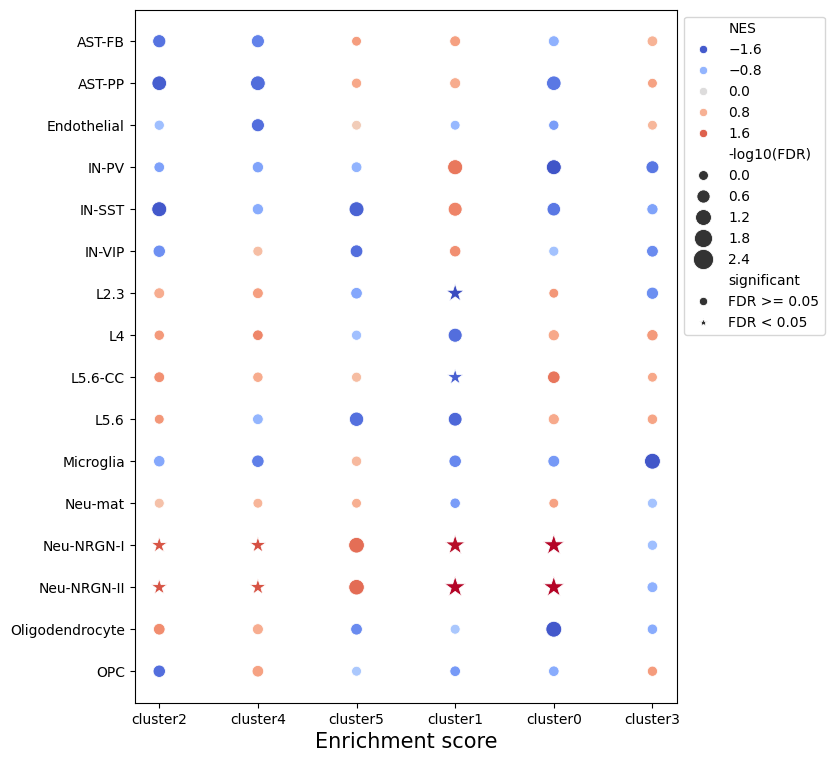

In [117]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    hue_norm=enrich_norm,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_40924\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


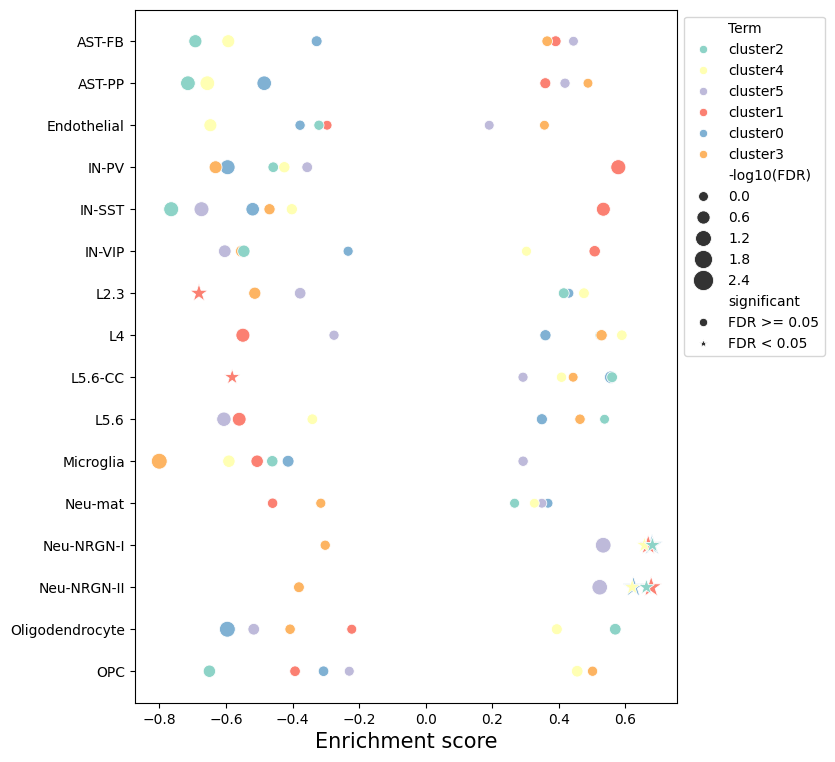

In [118]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

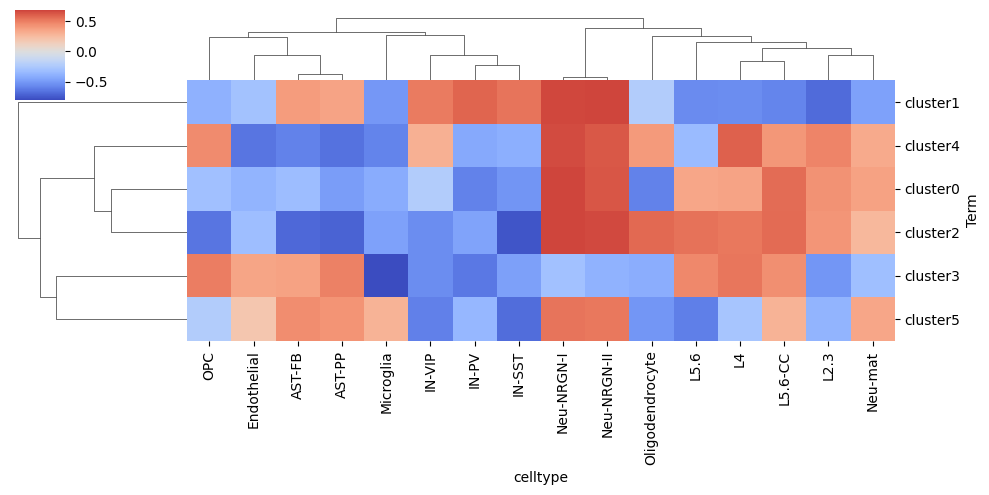

In [119]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

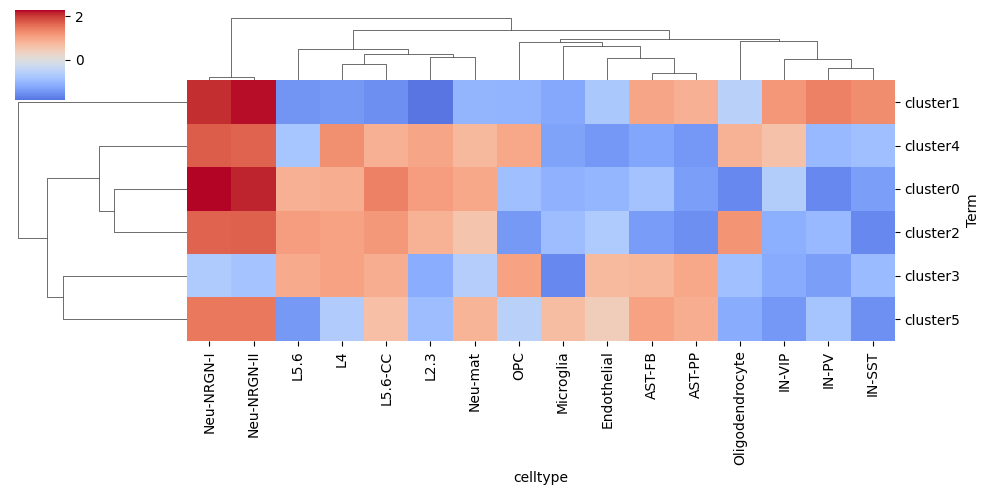

In [120]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

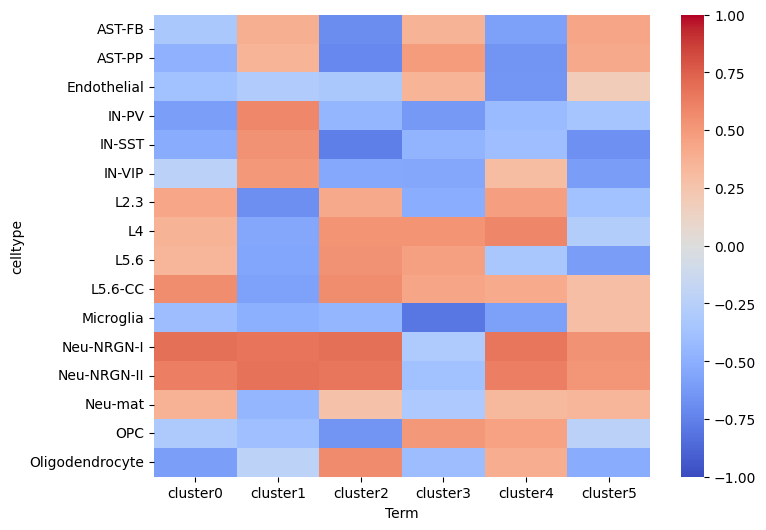

In [121]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Gene visualization

Calculate average normalized expression

In [122]:
for cluster in gene_sets.keys():
    genes = scaled_adata.var_names.intersection(gene_sets[cluster])
    scaled_adata.obs[f'{cluster}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

cluster     sample  individual region  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24       Neu-NRGN-II  1823_BA24        1823    ACC   
AAACGGGCACCAGATT-1_1823_BA24              L5/6  1823_BA24        1823    ACC   
AAAGATGAGTCCAGGA-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   
AAAGATGTCTTGAGGT-1_1823_BA24               OPC  1823_BA24        1823    ACC   
AAAGCAAGTAATCACC-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   

                              age sex diagnosis Capbatch Seqbatch  \
cell                                                                
AAACCTGGTACGCACC-1_1823_BA24   15   M   Control      CB8      SB3   
AAACGGGCACCAGATT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGAGTCCAGGA-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGTCTTGAGGT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGCAAGTAATCACC-1_1823_BA24   15   M   Control      CB8      SB3   

                              post-mortem interval (hours)  ...  \
cell                                                        ...   
AAACCTGGTACGCACC-1_1823_BA24                            18  ...   
AAACGGGCACCAGATT-1_1823_BA24                            18  ...   
AAAGATGAGTCCAGGA-1_1823_BA24                            18  ...   
AAAGATGTCTTGAGGT-1_1823_BA24                            18  ...   
AAAGCAAGTAATCACC-1_1823_BA24                            18  ...   

                              age-specific_scaled  maybe age-specific_scaled  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24             0.044794                   0.009079   
AAACGGGCACCAGATT-1_1823_BA24             0.370995                   0.404136   
AAAGATGAGTCCAGGA-1_1823_BA24            -0.209721                  -0.137062   
AAAGATGTCTTGAGGT-1_1823_BA24            -0.008599                  -0.022424   
AAAGCAAGTAATCACC-1_1823_BA24            -0.324078                  -0.114486   

                              maybe human-specific_scaled  \
cell                                                        
AAACCTGGTACGCACC-1_1823_BA24                     0.631965   
AAACGGGCACCAGATT-1_1823_BA24                     0.368279   
AAAGATGAGTCCAGGA-1_1823_BA24                     0.298023   
AAAGATGTCTTGAGGT-1_1823_BA24                    -0.364175   
AAAGCAAGTAATCACC-1_1823_BA24                     0.141202   

                              human-specific_scaled  cluster0_scaled  \
cell                                                                   
AAACCTGGTACGCACC-1_1823_BA24              -0.255659        -0.016111   
AAACGGGCACCAGATT-1_1823_BA24               0.472470         0.264299   
AAAGATGAGTCCAGGA-1_1823_BA24              -0.255659        -0.278907   
AAAGATGTCTTGAGGT-1_1823_BA24               0.350315         0.262971   
AAAGCAAGTAATCACC-1_1823_BA24               0.210459        -0.060483   

                              cluster1_scaled  cluster2_scaled  \
cell                                                             
AAACCTGGTACGCACC-1_1823_BA24        -0.323755         0.504019   
AAACGGGCACCAGATT-1_1823_BA24         0.486479         0.699806   
AAAGATGAGTCCAGGA-1_1823_BA24        -0.323755        -0.032619   
AAAGATGTCTTGAGGT-1_1823_BA24        -0.111883        -0.161333   
AAAGCAAGTAATCACC-1_1823_BA24        -0.323755         0.378125   

                              cluster3_scaled  cluster4_scaled  \
cell                                                             
AAACCTGGTACGCACC-1_1823_BA24         0.750432        -0.020163   
AAACGGGCACCAGATT-1_1823_BA24         0.535518         0.503458   
AAAGATGAGTCCAGGA-1_1823_BA24         0.676780         0.011073   
AAAGATGTCTTGAGGT-1_1823_BA24         0.096699        -0.169142   
AAAGCAAGTAATCACC-1_1823_BA24        -0.600390         0.314590   

                              cluster5_scaled  
cell                                           
AAACCTGG

Vusualize

In [123]:
scaled_adata.obs.columns

Index(['cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis',
       'Capbatch', 'Seqbatch', 'post-mortem interval (hours)',
       'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent',
       'RNA ribosomal percent', 'All HS genes', 'age-specific_scaled',
       'maybe age-specific_scaled', 'maybe human-specific_scaled',
       'human-specific_scaled', 'cluster0_scaled', 'cluster1_scaled',
       'cluster2_scaled', 'cluster3_scaled', 'cluster4_scaled',
       'cluster5_scaled'],
      dtype='object')

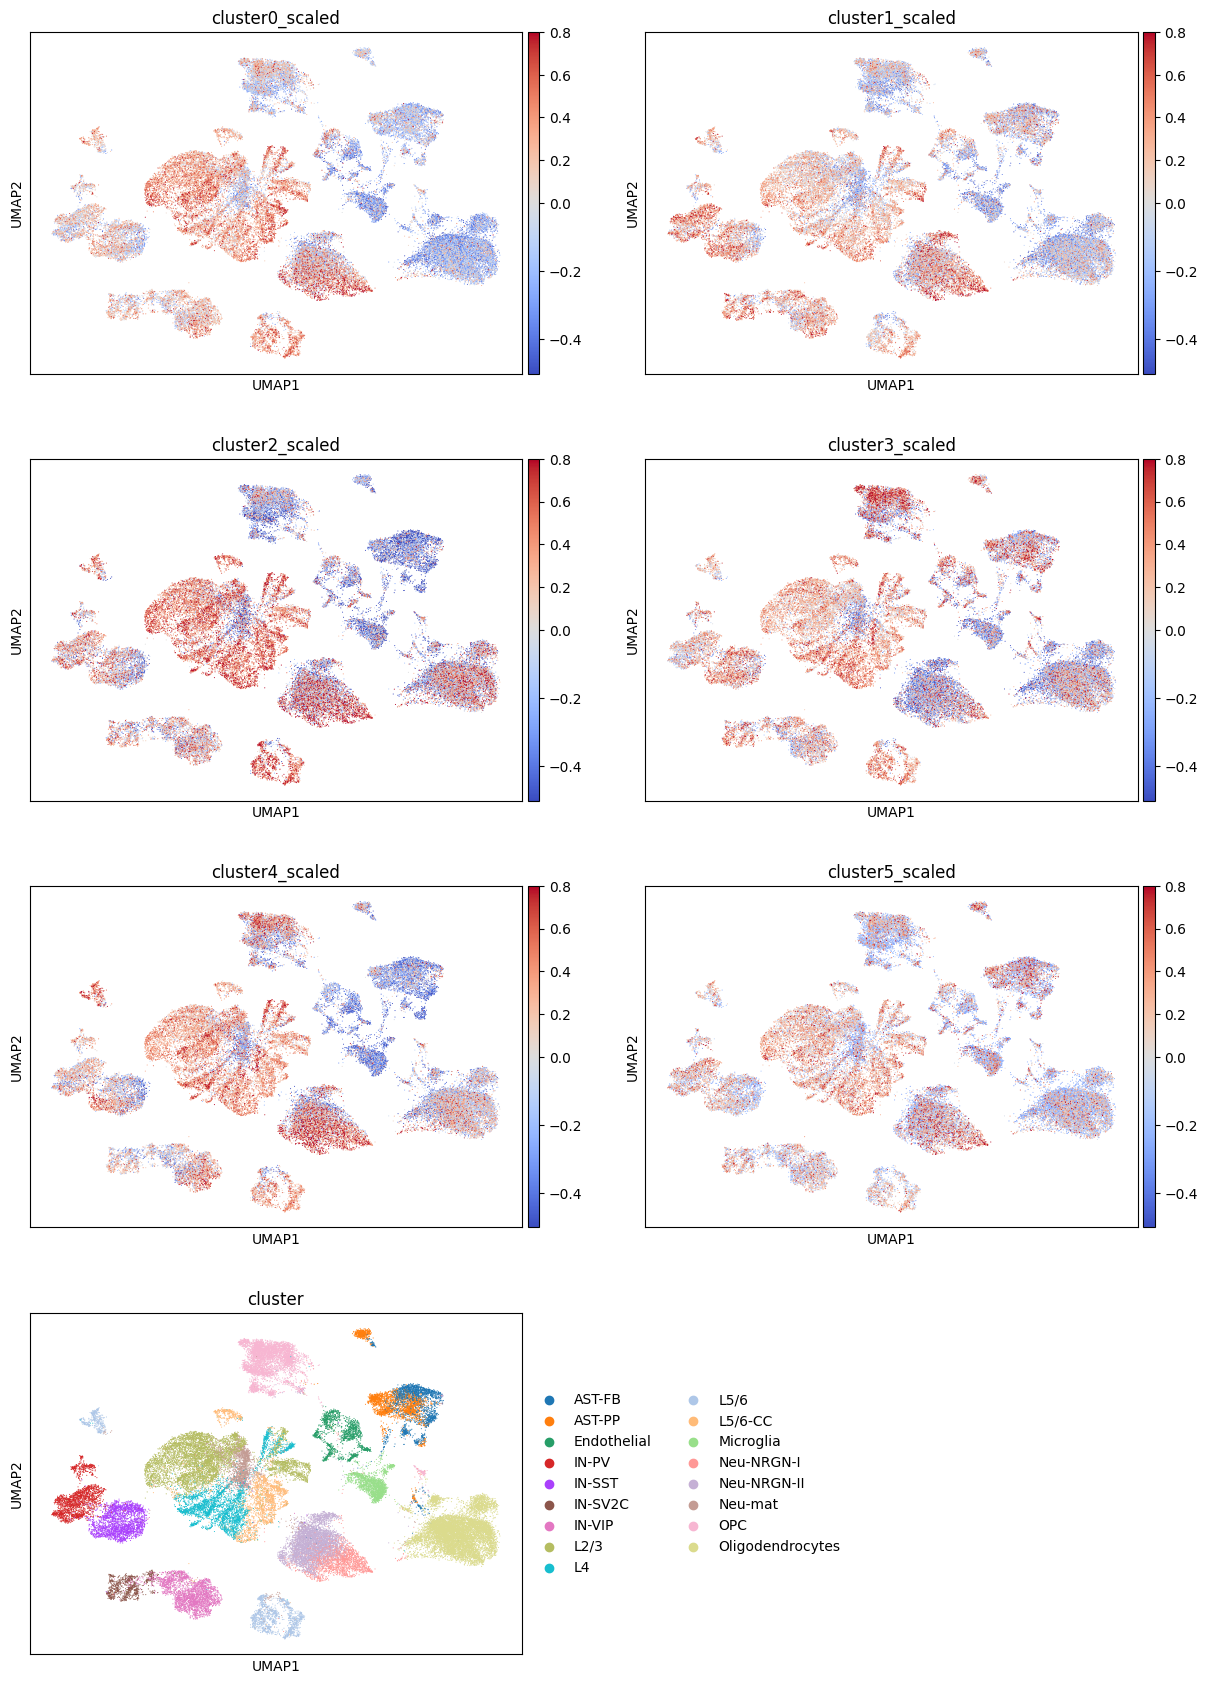

In [124]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.8, vmin=-0.5)
color = [
    'cluster0_scaled', 
    'cluster1_scaled',
    'cluster2_scaled', 
    'cluster3_scaled', 
    'cluster4_scaled',
    'cluster5_scaled', 
    'cluster'
    ]

sc.pl.umap(scaled_adata, color=color, cmap=cmap, norm=norm, ncols=2)

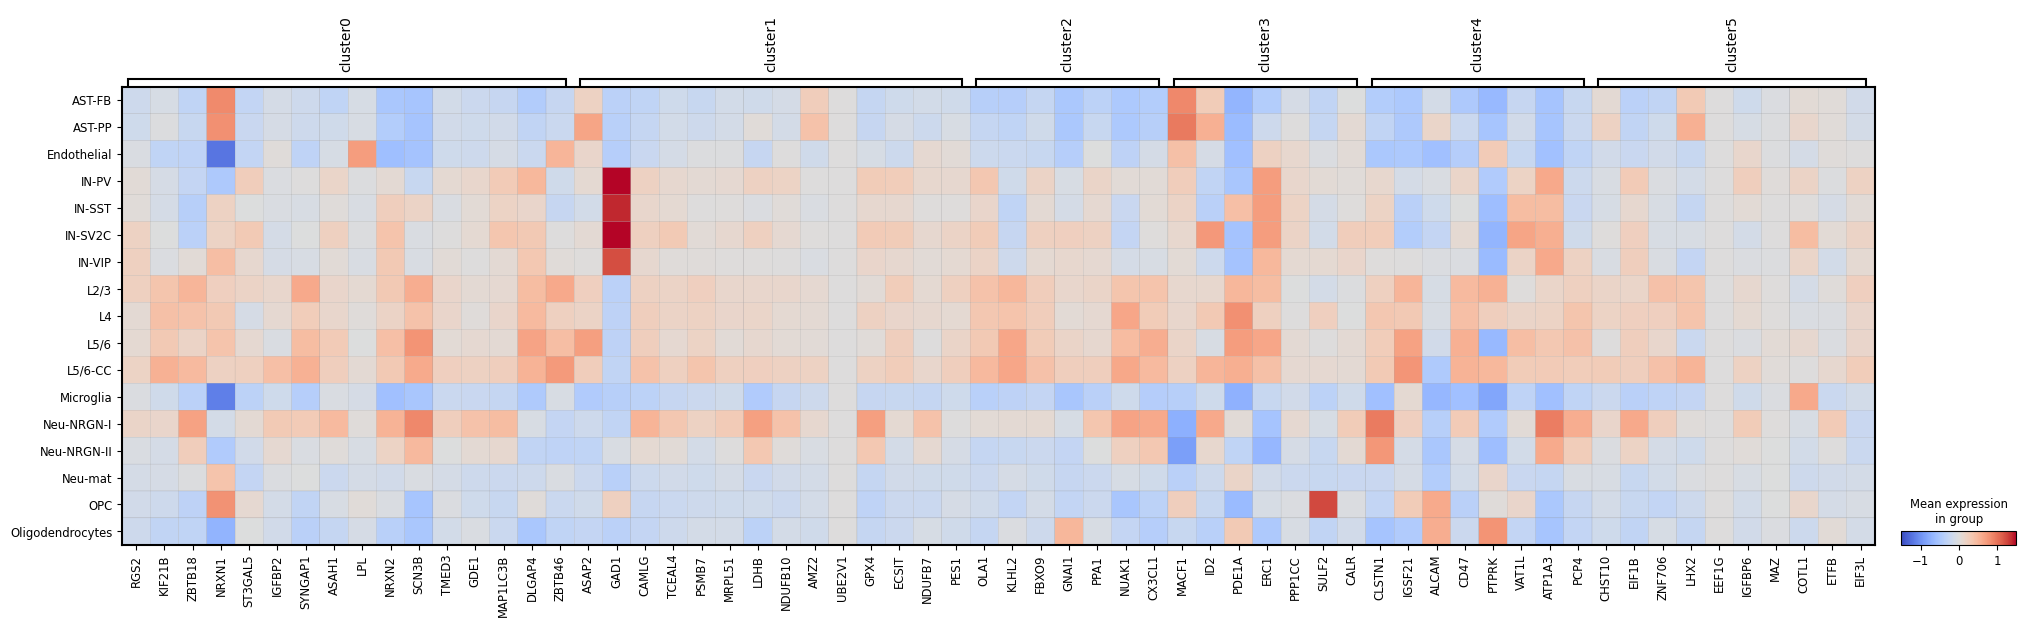

In [125]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

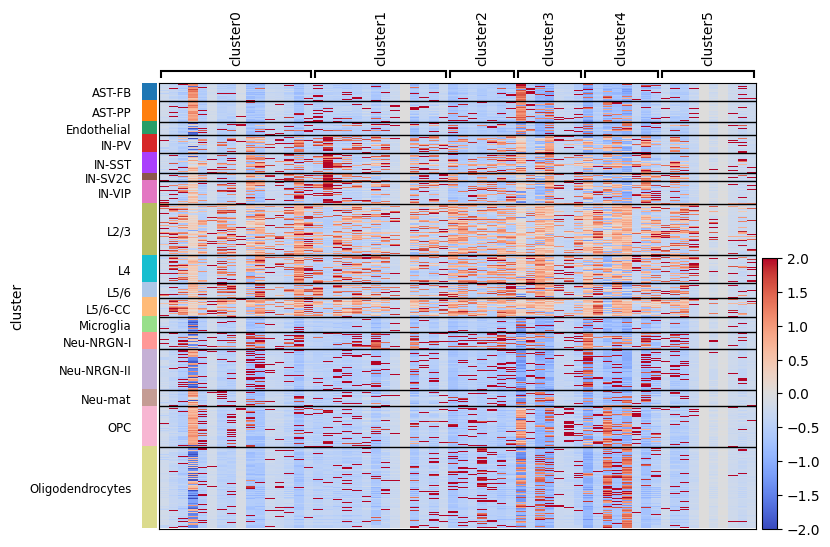

In [126]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', norm=norm)

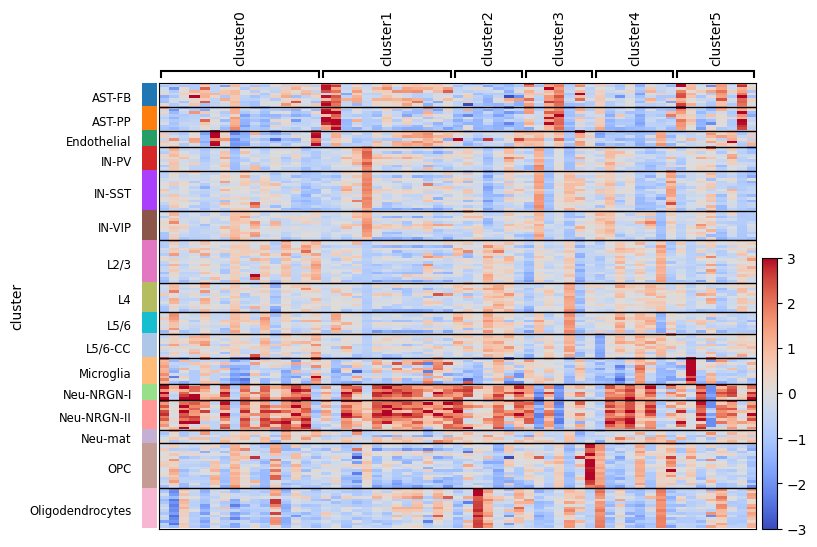

In [127]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='cluster', cmap='coolwarm', vcenter=0, vmin=-3, vmax=3)

## Enrichment for chimp-specific genes

Create a dict with genesets

In [128]:
geneset = {'chimp-specific genes': chimp_specific_genes}

### T-test

Specify DE test

In [129]:
key = 't-test'

Run enrichment for genesets

In [130]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:10:20,618 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:22,024 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:22,700 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:23,354 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:24,022 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:24,643 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.739787  1.863571       0.0       0.0   
0  prerank  chimp-specific genes   0.49288  1.282861  0.162393  0.162393   

  FWER p-val Tag % Gene %                                   Lead_genes  \
0        0.0  6/13  4.62%         SLC1A3;TPD52L1;HTRA1;BPTF;BCL6;MASP1   
0      0.057  7/13  9.00%  SLC1A3;HTRA1;TPD52L1;MASP1;SEMA3A;BPTF;BCL6   

  celltype  
0   AST-FB  
0   AST-PP

Process enrichment results

In [131]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.739787  1.863571       0.0       0.0   
0  prerank  chimp-specific genes   0.49288  1.282861  0.162393  0.162393   

  FWER p-val Tag % Gene %                                   Lead_genes  \
0        0.0  6/13  4.62%         SLC1A3;TPD52L1;HTRA1;BPTF;BCL6;MASP1   
0      0.057  7/13  9.00%  SLC1A3;HTRA1;TPD52L1;MASP1;SEMA3A;BPTF;BCL6   

  celltype  -log10(FDR) direction  significant  
0   AST-FB     3.000000  enriched   FDR < 0.05  
0   AST-PP     0.786766  enriched  FDR >= 0.05

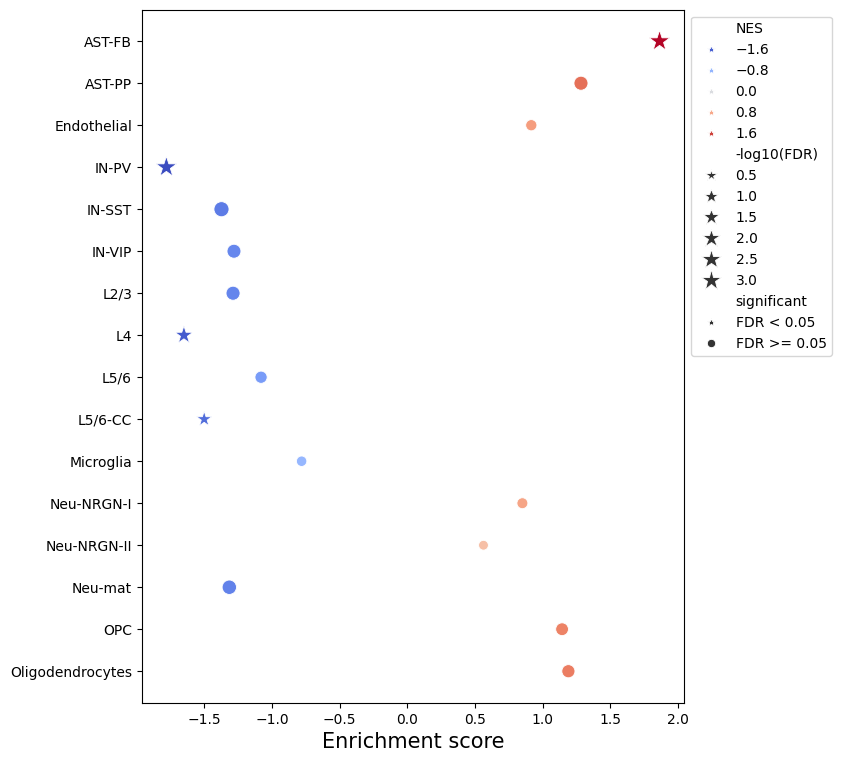

In [132]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Wilcoxon

Specify DE test

In [133]:
key = 'wilcoxon'

Run enrichment for genesets

In [134]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:10:30,645 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:31,296 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:31,950 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:32,611 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:33,248 [WARNING] Duplicated values found in preranked stats: 0.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:33,870 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.804277  1.562103  0.016502  0.016502   
0  prerank  chimp-specific genes  0.467106  0.984634  0.458221  0.458221   

  FWER p-val Tag % Gene %                       Lead_genes celltype  
0      0.005  5/13  3.22%  SLC1A3;TPD52L1;MASP1;BCL6;HTRA1   AST-FB  
0       0.17  5/13  3.47%  SLC1A3;TPD52L1;MASP1;BCL6;HTRA1   AST-PP

Process enrichment results

In [135]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.804277  1.562103  0.016502  0.016502   
0  prerank  chimp-specific genes  0.467106  0.984634  0.458221  0.458221   

  FWER p-val Tag % Gene %                       Lead_genes celltype  \
0      0.005  5/13  3.22%  SLC1A3;TPD52L1;MASP1;BCL6;HTRA1   AST-FB   
0       0.17  5/13  3.47%  SLC1A3;TPD52L1;MASP1;BCL6;HTRA1   AST-PP   

   -log10(FDR) direction  significant  
0     1.756921  enriched   FDR < 0.05  
0     0.337978  enriched  FDR >= 0.05

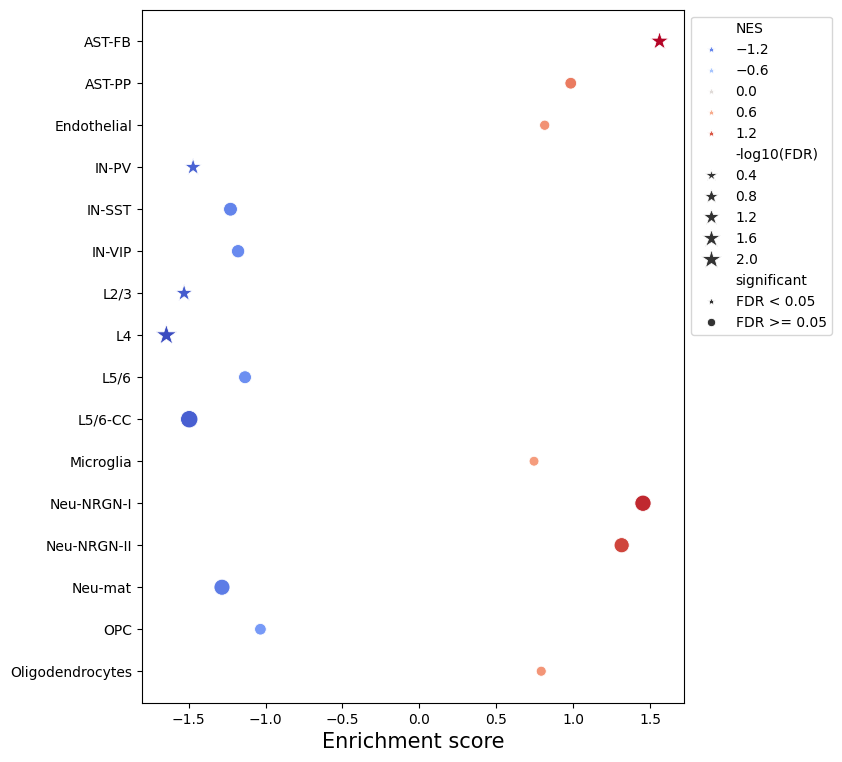

In [136]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Logreg

Specify DE test

In [137]:
key = 'logreg'

Run enrichment for genesets

In [138]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:10:42,856 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:43,550 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:44,201 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:44,778 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:45,408 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:46,056 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.799962   1.86686       0.0       0.0   
0  prerank  chimp-specific genes  0.539019  1.233137  0.214128  0.214128   

  FWER p-val Tag %  Gene %                                         Lead_genes  \
0        0.0  9/13  10.41%  SLC1A3;HTRA1;MRPL23;BCL6;SPARC;TPD52L1;BPTF;MA...   
0      0.097  4/13   1.90%                        SLC1A3;TPD52L1;SEMA3A;HTRA1   

  celltype  
0   AST-FB  
0   AST-PP

Process enrichment results

In [139]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.799962   1.86686       0.0       0.0   
0  prerank  chimp-specific genes  0.539019  1.233137  0.214128  0.214128   

  FWER p-val Tag %  Gene %                                         Lead_genes  \
0        0.0  9/13  10.41%  SLC1A3;HTRA1;MRPL23;BCL6;SPARC;TPD52L1;BPTF;MA...   
0      0.097  4/13   1.90%                        SLC1A3;TPD52L1;SEMA3A;HTRA1   

  celltype  -log10(FDR) direction  significant  
0   AST-FB     3.000000  enriched   FDR < 0.05  
0   AST-PP     0.667303  enriched  FDR >= 0.05

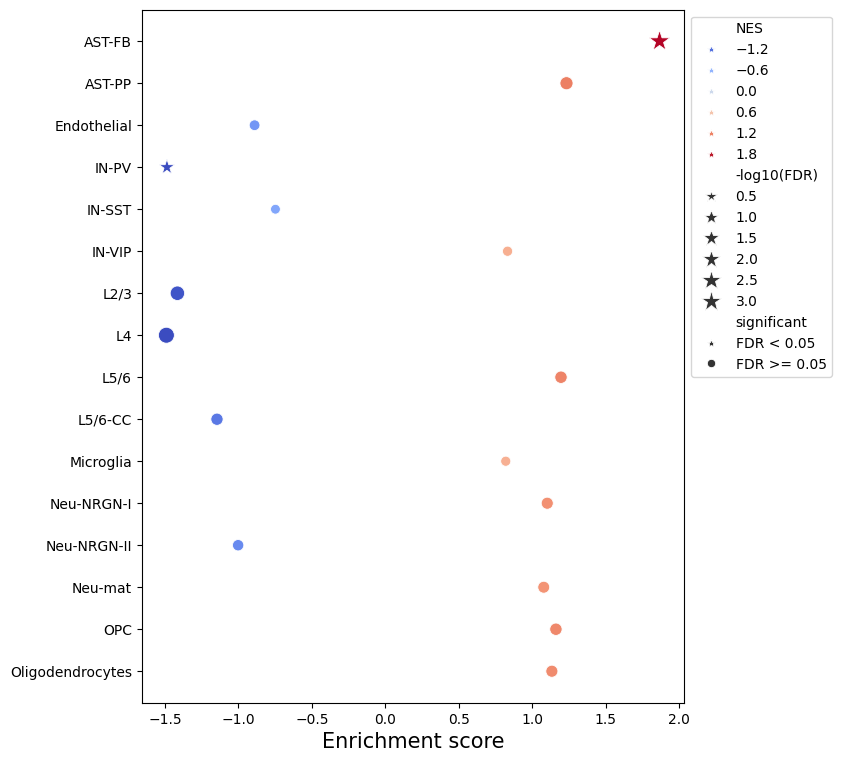

In [140]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR

Run enrichment for genesets

In [141]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True, 'weight': 0.5})
enrich_df.head(2)

  0%|          | 0/16 [00:00<?, ?it/s]

2024-07-30 17:10:51,759 [WARNING] Duplicated values found in preranked stats: 2.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:51,760 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:10:51,762 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-30 17:10:51,763 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-30 17:10:51,764 [INFO] Start to run GSEA...Might take a while..................
2024-07-30 17:10:52,396 [INFO] Congratulations. GSEApy runs successfully................

2024-07-30 17:10:52,407 [WARNING] Duplicated values found in preranked stats: 1.29% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-30 17:10:52,408 [INFO] Parsing data files for GSEA.............................
2024-07-30 17:10:52,410 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.752765  1.582189  0.015332  0.015332   
0  prerank  chimp-specific genes  0.730729  1.490746  0.028701  0.028701   

  FWER p-val Tag % Gene %                                   Lead_genes  \
0      0.009  5/13  3.69%              SLC1A3;TPD52L1;HTRA1;MASP1;BCL6   
0      0.019  7/13  9.61%  SLC1A3;TPD52L1;HTRA1;BCL6;MASP1;SEMA3A;BPTF   

  celltype  
0   AST-FB  
0   AST-PP

Process enrichment results

In [142]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.752765  1.582189  0.015332  0.015332   
0  prerank  chimp-specific genes  0.730729  1.490746  0.028701  0.028701   

  FWER p-val Tag % Gene %                                   Lead_genes  \
0      0.009  5/13  3.69%              SLC1A3;TPD52L1;HTRA1;MASP1;BCL6   
0      0.019  7/13  9.61%  SLC1A3;TPD52L1;HTRA1;BCL6;MASP1;SEMA3A;BPTF   

  celltype  -log10(FDR) direction significant  
0   AST-FB     1.786955  enriched  FDR < 0.05  
0   AST-PP     1.527230  enriched  FDR < 0.05

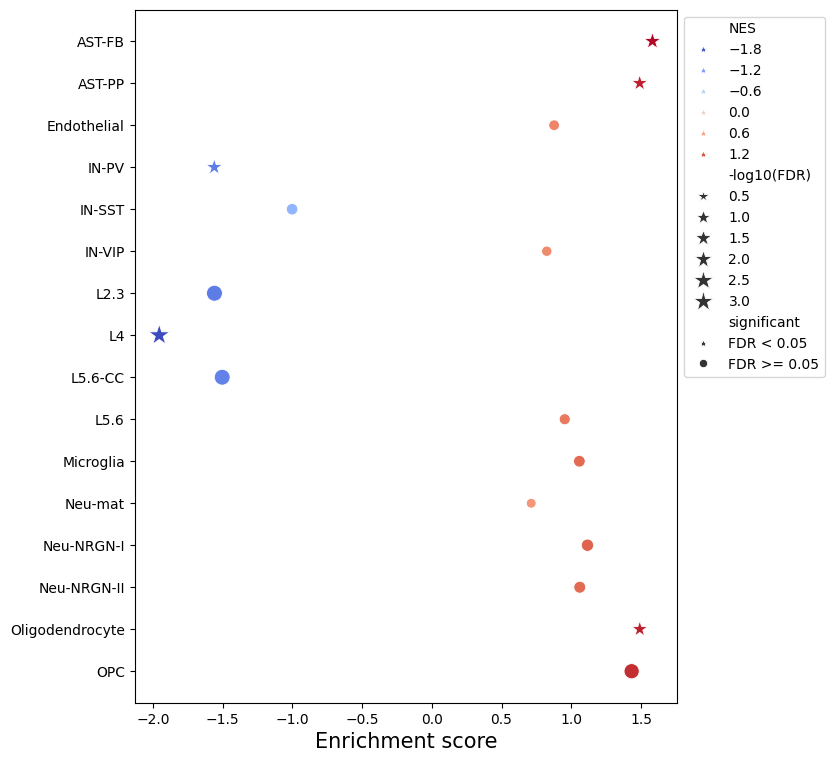

In [143]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Gene visualization

Calculate average normalized expression

In [144]:
genes = scaled_adata.var_names.intersection(chimp_specific_genes)
scaled_adata.obs[f'chimp_specific_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

cluster     sample  individual region  \
cell                                                                           
AAACCTGGTACGCACC-1_1823_BA24       Neu-NRGN-II  1823_BA24        1823    ACC   
AAACGGGCACCAGATT-1_1823_BA24              L5/6  1823_BA24        1823    ACC   
AAAGATGAGTCCAGGA-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   
AAAGATGTCTTGAGGT-1_1823_BA24               OPC  1823_BA24        1823    ACC   
AAAGCAAGTAATCACC-1_1823_BA24  Oligodendrocytes  1823_BA24        1823    ACC   

                              age sex diagnosis Capbatch Seqbatch  \
cell                                                                
AAACCTGGTACGCACC-1_1823_BA24   15   M   Control      CB8      SB3   
AAACGGGCACCAGATT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGAGTCCAGGA-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGATGTCTTGAGGT-1_1823_BA24   15   M   Control      CB8      SB3   
AAAGCAAGTAATCACC-1_1823_BA24   15   M   Control      CB8      SB3   

                              post-mortem interval (hours)  ...  \
cell                                                        ...   
AAACCTGGTACGCACC-1_1823_BA24                            18  ...   
AAACGGGCACCAGATT-1_1823_BA24                            18  ...   
AAAGATGAGTCCAGGA-1_1823_BA24                            18  ...   
AAAGATGTCTTGAGGT-1_1823_BA24                            18  ...   
AAAGCAAGTAATCACC-1_1823_BA24                            18  ...   

                              maybe age-specific_scaled  \
cell                                                      
AAACCTGGTACGCACC-1_1823_BA24                   0.009079   
AAACGGGCACCAGATT-1_1823_BA24                   0.404136   
AAAGATGAGTCCAGGA-1_1823_BA24                  -0.137062   
AAAGATGTCTTGAGGT-1_1823_BA24                  -0.022424   
AAAGCAAGTAATCACC-1_1823_BA24                  -0.114486   

                              maybe human-specific_scaled  \
cell                                                        
AAACCTGGTACGCACC-1_1823_BA24                     0.631965   
AAACGGGCACCAGATT-1_1823_BA24                     0.368279   
AAAGATGAGTCCAGGA-1_1823_BA24                     0.298023   
AAAGATGTCTTGAGGT-1_1823_BA24                    -0.364175   
AAAGCAAGTAATCACC-1_1823_BA24                     0.141202   

                              human-specific_scaled  cluster0_scaled  \
cell                                                                   
AAACCTGGTACGCACC-1_1823_BA24              -0.255659        -0.016111   
AAACGGGCACCAGATT-1_1823_BA24               0.472470         0.264299   
AAAGATGAGTCCAGGA-1_1823_BA24              -0.255659        -0.278907   
AAAGATGTCTTGAGGT-1_1823_BA24               0.350315         0.262971   
AAAGCAAGTAATCACC-1_1823_BA24               0.210459        -0.060483   

                              cluster1_scaled  cluster2_scaled  \
cell                                                             
AAACCTGGTACGCACC-1_1823_BA24        -0.323755         0.504019   
AAACGGGCACCAGATT-1_1823_BA24         0.486479         0.699806   
AAAGATGAGTCCAGGA-1_1823_BA24        -0.323755        -0.032619   
AAAGATGTCTTGAGGT-1_1823_BA24        -0.111883        -0.161333   
AAAGCAAGTAATCACC-1_1823_BA24        -0.323755         0.378125   

                              cluster3_scaled  cluster4_scaled  \
cell                                                             
AAACCTGGTACGCACC-1_1823_BA24         0.750432        -0.020163   
AAACGGGCACCAGATT-1_1823_BA24         0.535518         0.503458   
AAAGATGAGTCCAGGA-1_1823_BA24         0.676780         0.011073   
AAAGATGTCTTGAGGT-1_1823_BA24         0.096699        -0.169142   
AAAGCAAGTAATCACC-1_1823_BA24        -0.600390         0.314590   

                              cluster5_scaled  chimp_specific_scaled  
cell                                                                  
AAACCTGGTACGCACC-1_1823_BA24         0.213109              -0.380711  
AAACGGGCACCAGATT-1_1823_BA24         0

Vusualize

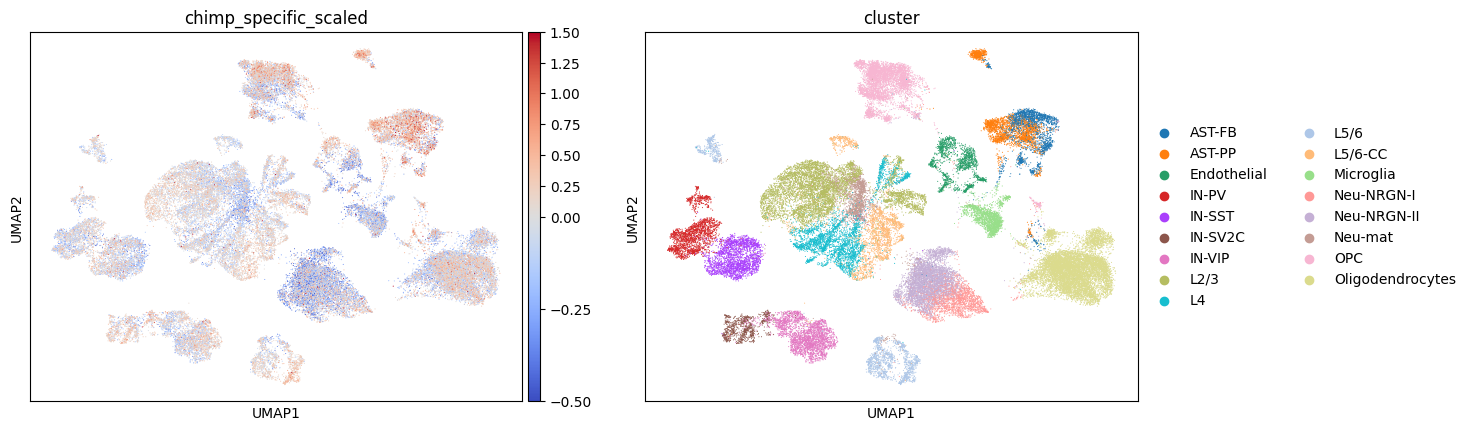

In [145]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-0.5)

sc.pl.umap(scaled_adata, color=['chimp_specific_scaled', 'cluster'], cmap=cmap, norm=norm)

In [146]:
gene_sets = dict()
for label in chimp_cluster_groups.label.unique():
  gene_sets[f'cluster{label}'] = chimp_cluster_groups[chimp_cluster_groups.label == label].index.to_list()

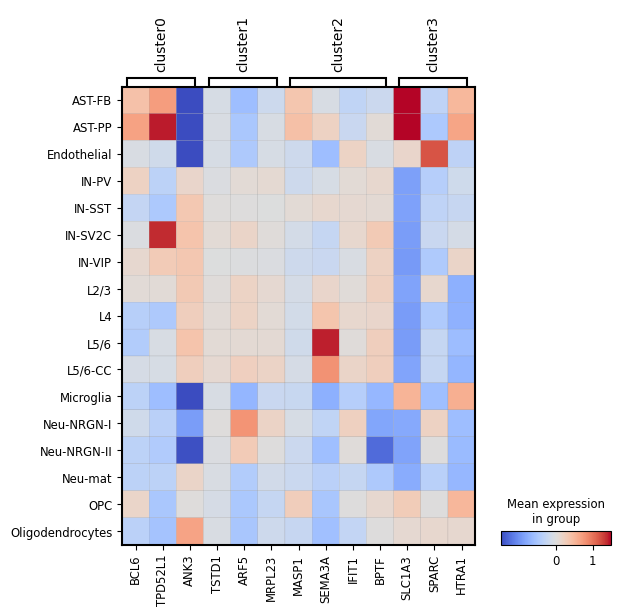

In [147]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', vcenter=0, vmin=-0.7, vmax=1.5)

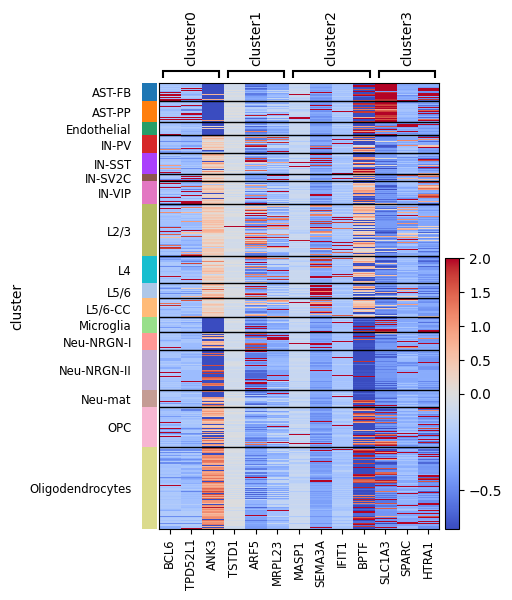

In [148]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='cluster', cmap='coolwarm', vcenter=0, vmin=-0.7, vmax=2)

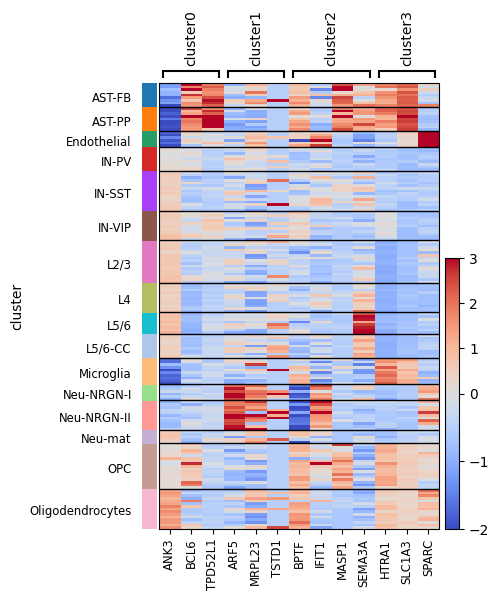

In [149]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='cluster', cmap='coolwarm', vcenter=0, vmin=-2, vmax=3)